In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## load and visualize

In [2]:
# tool function
# pie_average
def pie_average_wedge(Qx, Qy, I, dI=None, *,
                      center_angle_rad=0.0,
                      half_width_rad=np.deg2rad(5.0),
                      nbins=120,
                      Qmin=None, Qmax=None,
                      use_weighted=True,
                      return_counts=False):
    """
    Pie-average intensity in a wedge around center_angle_rad.
    Angles are defined in standard polar coordinates: theta = arctan2(Qy, Qx).

    Parameters
    ----------
    Qx, Qy, I : 1D arrays
    dI : 1D array or None
        If provided and use_weighted=True, weights = 1/dI^2.
    center_angle_rad : float
        Wedge center angle. para ~ 0, perp ~ pi/2.
    half_width_rad : float
        Half wedge width (e.g., 5 degrees => +/-5 deg).
    nbins : int
        Number of radial Q bins.
    Qmin, Qmax : float or None
        Radial range. If None, inferred from wedge-selected points.
    use_weighted : bool
        If True and dI is provided, compute weighted mean.
        Else use simple mean.
    return_counts : bool
        If True, also return counts per bin.

    Returns
    -------
    Q_centers : 1D array
    I_binned  : 1D array
    dI_binned : 1D array (if dI provided), else None
    counts    : 1D array (if return_counts=True)
    """
    Qx = np.asarray(Qx); Qy = np.asarray(Qy); I = np.asarray(I)

    # Basic finite mask
    m = np.isfinite(Qx) & np.isfinite(Qy) & np.isfinite(I)
    if dI is not None:
        dI = np.asarray(dI)
        m &= np.isfinite(dI) & (dI > 0)

    Qx, Qy, I = Qx[m], Qy[m], I[m]
    dI_use = dI[m] if dI is not None else None

    Q = np.sqrt(Qx**2 + Qy**2)
    theta = np.arctan2(Qy, Qx)  # (-pi, pi]

    # Smallest signed angular difference in [-pi, pi]
    dtheta = (theta - center_angle_rad + np.pi) % (2*np.pi) - np.pi
    mw = np.abs(dtheta) <= half_width_rad

    Qw, Iw = Q[mw], I[mw]
    dIw = dI_use[mw] if dI_use is not None else None

    if Qw.size == 0:
        raise ValueError("No points found in wedge; widen half_width_rad or check data orientation.")

    if Qmin is None: Qmin = np.nanmin(Qw)
    if Qmax is None: Qmax = np.nanmax(Qw)
    if Qmax <= Qmin:
        raise ValueError("Invalid Q range after wedge selection.")

    edges = np.linspace(Qmin, Qmax, nbins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_id = np.digitize(Qw, edges) - 1
    good = (bin_id >= 0) & (bin_id < nbins)

    bin_id = bin_id[good]
    Iw = Iw[good]
    if dIw is not None:
        dIw = dIw[good]

    counts = np.bincount(bin_id, minlength=nbins)

    if (dIw is not None) and use_weighted:
        w = 1.0 / (dIw**2)
        sumw = np.bincount(bin_id, weights=w, minlength=nbins)
        sumwI = np.bincount(bin_id, weights=w*Iw, minlength=nbins)
        I_binned = np.divide(sumwI, sumw, out=np.full(nbins, np.nan), where=(sumw > 0))

        # standard error of weighted mean (measurement-noise-only)
        dI_binned = np.divide(1.0, np.sqrt(sumw), out=np.full(nbins, np.nan), where=(sumw > 0))
    else:
        sumI = np.bincount(bin_id, weights=Iw, minlength=nbins)
        I_binned = np.divide(sumI, counts, out=np.full(nbins, np.nan), where=(counts > 0))
        dI_binned = None
        if dIw is not None:
            # conservative: combine reported dI by RMS / sqrt(N)
            sum_dI2 = np.bincount(bin_id, weights=dIw**2, minlength=nbins)
            dI_binned = np.divide(np.sqrt(sum_dI2), counts, out=np.full(nbins, np.nan), where=(counts > 0))

    # Keep only bins with data
    keep = counts > 0
    out = (centers[keep], I_binned[keep])
    if dI is not None:
        out = out + (dI_binned[keep],)
    if return_counts:
        out = out + (counts[keep],)
    return out


# match eqsans curves
def _powerlaw_fit_loglog(Q, I):
    """
    Fit log(I) = b + m*log(Q). Returns (m, b).
    """
    x = np.log(Q)
    y = np.log(I)
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, b

def _vertical_shift_factor_powerlaw(
    Q_ref, I_ref,
    Q_seg, I_seg,
    q_overlap=None,
    min_points=12,
    q_pad=0.0,
):
    """
    Compute multiplicative factor s so that s*I_seg matches power-law extrapolation
    of I_ref in the overlap region.

    q_overlap:
      - None: auto overlap = intersection of Q ranges
      - (qmin, qmax): explicit overlap window
    q_pad: shrink overlap window by a fraction of its width (0..0.49) to avoid edge issues.
    """
    # sanitize: positive only for log fits
    mask_ref = (Q_ref > 0) & (I_ref > 0) & np.isfinite(Q_ref) & np.isfinite(I_ref)
    mask_seg = (Q_seg > 0) & (I_seg > 0) & np.isfinite(Q_seg) & np.isfinite(I_seg)
    Qr, Ir = Q_ref[mask_ref], I_ref[mask_ref]
    Qs, Is = Q_seg[mask_seg], I_seg[mask_seg]

    if Qr.size < min_points or Qs.size < min_points:
        return 1.0  # not enough data to be meaningful

    # overlap window
    if q_overlap is None:
        qmin = max(np.min(Qr), np.min(Qs))
        qmax = min(np.max(Qr), np.max(Qs))
    else:
        qmin, qmax = q_overlap

    if not (np.isfinite(qmin) and np.isfinite(qmax)) or qmax <= qmin:
        return 1.0

    # optional shrink overlap window
    width = qmax - qmin
    qmin2 = qmin + q_pad * width
    qmax2 = qmax - q_pad * width
    if qmax2 <= qmin2:
        return 1.0

    # take overlap points
    r_ol = (Qr >= qmin2) & (Qr <= qmax2)
    s_ol = (Qs >= qmin2) & (Qs <= qmax2)

    if np.count_nonzero(r_ol) < min_points or np.count_nonzero(s_ol) < min_points:
        print("Warning: not enough overlap points for vertical shift fit.")
        return 1.0

    Qr_ol, Ir_ol = Qr[r_ol], Ir[r_ol]
    Qs_ol, Is_ol = Qs[s_ol], Is[s_ol]

    # fit power law on reference overlap
    m, b = _powerlaw_fit_loglog(Qr_ol, Ir_ol)

    # predict reference intensity at segment Q points (extrapolated power-law)
    Iref_fit_on_seg = np.exp(b + m * np.log(Qs_ol))

    # compute scale in log space (geometric mean ratio)
    log_ratio = np.log(Iref_fit_on_seg) - np.log(Is_ol)
    s = float(np.exp(np.mean(log_ratio)))

    if not np.isfinite(s) or s <= 0:
        s = 1.0
    return s

def concat_with_optional_powerlaw_shift(
    Q_lq, I_lq, dI_lq,
    Q_mq, I_mq, dI_mq,
    Q_hq, I_hq, dI_hq,
    do_shift=True,
    overlap_mq=None,   # (qmin,qmax) or None for auto
    overlap_hq=None,   # (qmin,qmax) or None for auto
    min_points=12,
    q_pad=0.0,
):
    """
    Low-Q is the base. Optionally shift MQ to match LQ, then shift HQ to match (LQ+MQ).
    Returns concatenated (Q, I, dI) and a dict of applied scale factors.
    """
    # start with low-Q as reference
    Q_ref = np.asarray(Q_lq)
    I_ref = np.asarray(I_lq)
    dI_ref = np.asarray(dI_lq)

    factors = {"mq": 1.0, "hq": 1.0}

    # shift MQ
    Q_mq = np.asarray(Q_mq); I_mq = np.asarray(I_mq); dI_mq = np.asarray(dI_mq)
    if do_shift:
        s_mq = _vertical_shift_factor_powerlaw(
            Q_ref, I_ref, Q_mq, I_mq,
            q_overlap=overlap_mq,
            min_points=min_points,
            q_pad=q_pad,
        )
        factors["mq"] = s_mq
        I_mq = I_mq * s_mq
        dI_mq = dI_mq * s_mq

    # update reference by concatenating LQ+MQ (temporarily) for HQ fit
    Q_ref2 = np.concatenate([Q_ref, Q_mq])
    I_ref2 = np.concatenate([I_ref, I_mq])
    dI_ref2 = np.concatenate([dI_ref, dI_mq])

    # shift HQ
    Q_hq = np.asarray(Q_hq); I_hq = np.asarray(I_hq); dI_hq = np.asarray(dI_hq)
    if do_shift:
        s_hq = _vertical_shift_factor_powerlaw(
            Q_ref2, I_ref2, Q_hq, I_hq,
            q_overlap=overlap_hq,
            min_points=min_points,
            q_pad=q_pad,
        )
        factors["hq"] = s_hq
        I_hq = I_hq * s_hq
        dI_hq = dI_hq * s_hq

    # final concatenation
    Q_all  = np.concatenate([Q_ref,  Q_mq,  Q_hq])
    I_all  = np.concatenate([I_ref,  I_mq,  I_hq])
    dI_all = np.concatenate([dI_ref, dI_mq, dI_hq])

    return Q_all, I_all, dI_all, factors

# concatnated error organizer
def organize_error_continuous_1d(
    Q, dI,
    *,
    half_window=10,
    mode="invvar",
    clamp_factor=1.1,
):
    """
    Construct a continuous error curve dI(Q) dominated by smallest errors.

    Parameters
    ----------
    Q, dI : 1D arrays (sorted by Q, Q>0)
    half_window : int
        Number of neighbors on each side in log-Q index space.
    mode : {"invvar", "min"}
        "invvar": inverse-variance pooling (recommended)
        "min":    hard minimum envelope
    clamp_factor : float
        Final dI will not exceed clamp_factor * local minimum dI.

    Returns
    -------
    dI_new : 1D array, same shape as dI
    """

    Q = np.asarray(Q)
    dI = np.asarray(dI)

    if np.any(Q <= 0):
        raise ValueError("Q must be positive.")
    if np.any(~np.isfinite(dI)) or np.any(dI <= 0):
        raise ValueError("dI must be finite and positive.")

    n = Q.size
    logQ = np.log(Q)
    logdI = np.log(dI)

    dI_out = np.full(n, np.nan)

    for i in range(n):
        lo = max(0, i - half_window)
        hi = min(n, i + half_window + 1)

        local_dI = dI[lo:hi]
        m = np.isfinite(local_dI)

        if np.count_nonzero(m) < 3:
            continue

        if mode == "min":
            dI_loc = np.min(local_dI[m])
        else:  # inverse-variance pooling
            w = 1.0 / local_dI[m]**2
            dI_loc = 1.0 / np.sqrt(np.sum(w))

        dI_out[i] = dI_loc

    # smooth in log-space (median filter)
    logdI_smooth = logdI.copy()
    for i in range(n):
        lo = max(0, i - half_window)
        hi = min(n, i + half_window + 1)
        vals = np.log(dI_out[lo:hi])
        vals = vals[np.isfinite(vals)]
        if vals.size >= 3:
            logdI_smooth[i] = np.median(vals)

    dI_smooth = np.exp(logdI_smooth)

    # clamp so error is dominated by smallest local error
    dI_min_local = np.minimum.accumulate(dI)
    dI_final = np.minimum(dI_smooth, clamp_factor * dI_min_local)

    return dI_final

# fit porod bg
def fit_porod_background(Q, I, dI=None, *, qmin_fit=None, qmax_fit=None,
                         use_weighted=True, n_iter=2, clip_sigma=4.0):
    """
    Fit I(Q) = a*Q^-4 + I_bg on a high-Q window [qmin_fit, qmax_fit].

    Returns
    -------
    a, I_bg, fit_mask
    """
    Q = np.asarray(Q); I = np.asarray(I)
    m = np.isfinite(Q) & np.isfinite(I) & (Q > 0)

    if dI is not None:
        dI = np.asarray(dI)
        m &= np.isfinite(dI) & (dI > 0)

    if qmin_fit is None:
        qmin_fit = np.quantile(Q[m], 0.85)  # default: top 15% of Q
    if qmax_fit is None:
        qmax_fit = np.max(Q[m])

    m &= (Q >= qmin_fit) & (Q <= qmax_fit)
    if np.count_nonzero(m) < 8:
        raise ValueError("Not enough points in high-Q fit window; adjust qmin_fit/qmax_fit.")

    # Design matrix for linear least squares in parameters [a, I_bg]
    X = np.vstack([Q[m]**(-4), np.ones(np.count_nonzero(m))]).T
    y = I[m]

    if (dI is not None) and use_weighted:
        w = 1.0 / (dI[m]**2)
    else:
        w = np.ones_like(y)

    # iterative sigma-clip on residuals (in intensity units)
    keep = np.ones_like(y, dtype=bool)
    for _ in range(max(1, n_iter)):
        Xk = X[keep]
        yk = y[keep]
        wk = w[keep]

        # Weighted normal equations: (X^T W X) beta = X^T W y
        W = wk
        XtW = Xk.T * W
        beta = np.linalg.lstsq(XtW @ Xk, XtW @ yk, rcond=None)[0]
        a, I_bg = float(beta[0]), float(beta[1])

        # residuals for clipping
        yhat = X @ beta
        resid = y - yhat
        # robust scale estimate
        mad = np.median(np.abs(resid[keep] - np.median(resid[keep])))
        sigma = 1.4826 * mad if mad > 0 else np.std(resid[keep])
        if not np.isfinite(sigma) or sigma <= 0:
            break
        keep = np.abs(resid) <= clip_sigma * sigma

        # ensure we don't clip too aggressively
        if np.count_nonzero(keep) < 6:
            keep[:] = True
            break

    # build full mask in original indexing for reporting
    fit_mask = np.zeros_like(Q, dtype=bool)
    idx_m = np.where(m)[0]
    fit_mask[idx_m] = keep

    return a, I_bg, fit_mask

def subtract_constant_background(I, dI, I_bg, *, floor_to_zero=False):
    """
    Subtract constant I_bg from I. dI unchanged (constant background subtraction).
    """
    I_corr = I - I_bg
    if floor_to_zero:
        I_corr = np.maximum(I_corr, 0.0)
    return I_corr, dI


Optimal epsilon: -0.38, Minimum loss: 0.04879313705014211


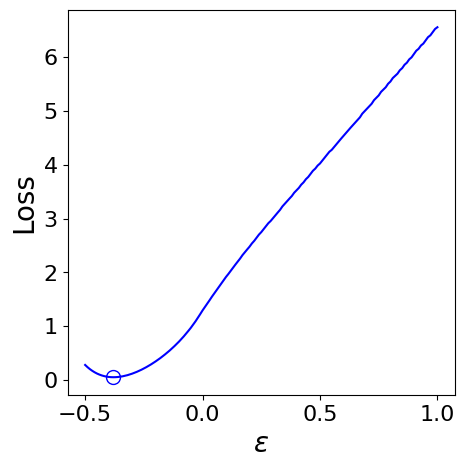

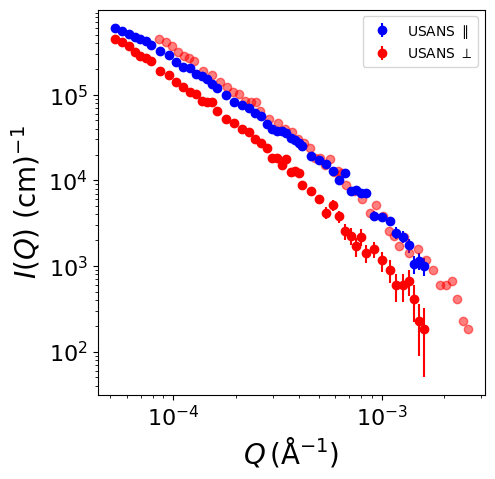

Low Q range: (-0.03395646, 0.03638733)
Mid Q range: (-0.08133716, 0.08950429)
High Q range: (-0.2799932, 0.3072851)


/tmp/ipykernel_1377955/1173480672.py:195: RuntimeWarning: invalid value encountered in log10
  c = ax.pcolormesh(Qx_grid_lq, Qy_grid_lq, np.log10(I_grid_lq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_lq).astype(float))


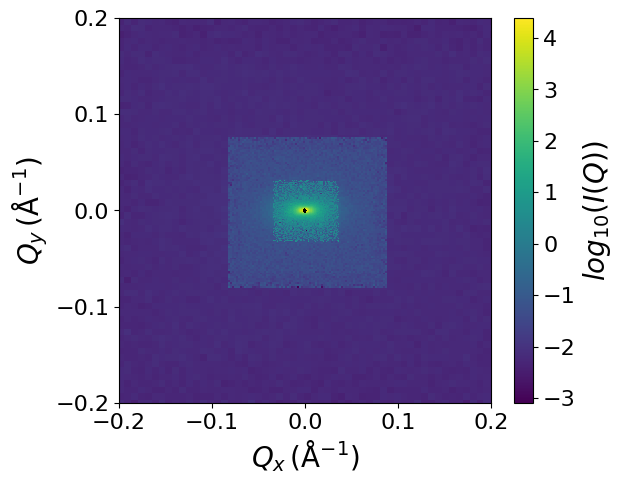

para factors: {'mq': 1.0613358813399818, 'hq': 2.922668095584892}
perp factors: {'mq': 1.170868331488444, 'hq': 3.2443141104836783}
PARA: a = 6.474857999816074e-05 I_bg = 0.2958353839478643
PERP: a = 1.2967033352555374e-05 I_bg = 0.3426623638572985


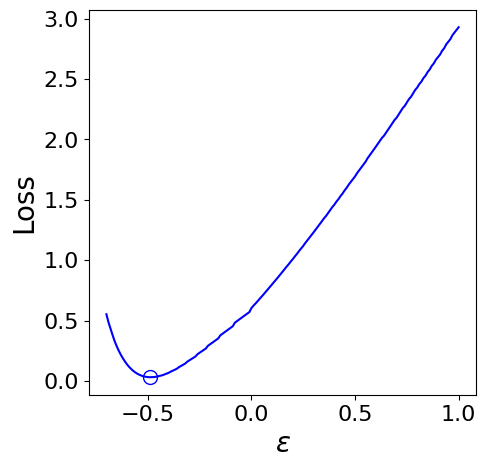

Optimal epsilon (SANS): -0.49, Minimum loss (SANS): 0.030541457622382202


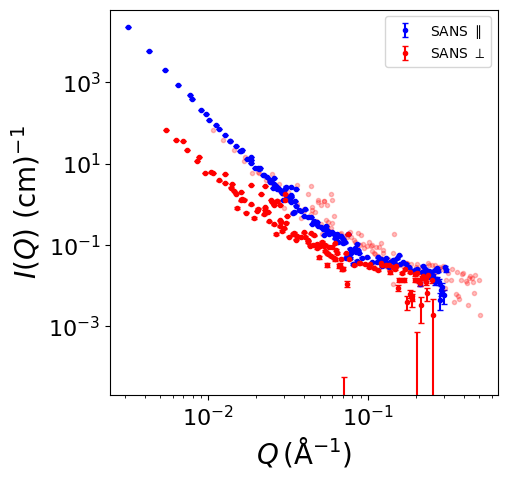

In [3]:
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize

sample_id = "1"

filename_USANS_para = f"./data/data_yyw/USANS_rawdata/sample{sample_id}_para_8mm.txt"
filename_USANS_perp = f"./data/data_yyw/USANS_rawdata/sample{sample_id}_perp_8mm.txt"
filename_SANS_para_lq = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf1_8m_Iqxqy.dat"
filename_SANS_para_mq = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf1_inc_Iqxqy.dat"
filename_SANS_para_hq = f"./data/data_yyw/EQ-SANS_rawdata/rawdata/s{sample_id}/s{sample_id}_conf2_inc_Iqxqy.dat"
# load USANS data
data_USANS_para = np.genfromtxt(filename_USANS_para, skip_header=0, delimiter=',', filling_values=np.nan)
data_USANS_perp = np.genfromtxt(filename_USANS_perp, skip_header=0, delimiter=',', filling_values=np.nan)

Q_obs_usans_para = data_USANS_para[:, 0]
I_obs_usans_para = data_USANS_para[:, 1]
dI_obs_usans_para = data_USANS_para[:, 2]
Q_obs_usans_para_mask = Q_obs_usans_para > 5e-5
Q_obs_usans_para = Q_obs_usans_para[Q_obs_usans_para_mask]
I_obs_usans_para = I_obs_usans_para[Q_obs_usans_para_mask]
dI_obs_usans_para = dI_obs_usans_para[Q_obs_usans_para_mask]

Q_obs_usans_perp = data_USANS_perp[:, 0]
I_obs_usans_perp = data_USANS_perp[:, 1]
dI_obs_usans_perp = data_USANS_perp[:, 2]
Q_obs_usans_perp_mask = Q_obs_usans_perp > 5e-5
Q_obs_usans_perp = Q_obs_usans_perp[Q_obs_usans_perp_mask]
I_obs_usans_perp = I_obs_usans_perp[Q_obs_usans_perp_mask]
dI_obs_usans_perp = dI_obs_usans_perp[Q_obs_usans_perp_mask]

# Log-transform (clip to avoid -inf if any zeros sneak in)
log_I_obs_usans_para = np.log(np.clip(I_obs_usans_para, 1e-300, None))
log_I_obs_usans_perp = np.log(np.clip(I_obs_usans_perp, 1e-300, None))

# Fit cubic polynomial in Q to log I
deg = 3
coeffs_para = np.polyfit(Q_obs_usans_para, log_I_obs_usans_para, deg)
coeffs_perp = np.polyfit(Q_obs_usans_perp, log_I_obs_usans_perp, deg)

# Use an overlap Q grid for comparison
Q_min = max(Q_obs_usans_para.min(), Q_obs_usans_perp.min())
Q_max = min(Q_obs_usans_para.max(), Q_obs_usans_perp.max())
Q_ref = np.linspace(Q_min, Q_max, 500)

# Loss: assume PERP Q-axis is stretched by (1+epsilon),
# meaning the perp curve at Q_ref should be compared to para at the same "physical" Q:
#   log I_para(Q_ref)  ≈  log I_perp((1+epsilon)*Q_ref)
def calculate_eps_loss(epsilon, Q_ref, coeffs_para, coeffs_perp,
                   Q_perp_min, Q_perp_max):
    s = 1.0 + epsilon
    if s <= 0:
        return np.inf  # invalid stretch

    Q_perp = s * Q_ref

    # Only compare where Q_perp stays inside the perp fit domain
    m = (Q_perp >= Q_perp_min) & (Q_perp <= Q_perp_max)
    if not np.any(m):
        return np.inf

    log_I_para = np.polyval(coeffs_para, Q_ref[m])
    log_I_perp = np.polyval(coeffs_perp, Q_perp[m])

    return np.mean((log_I_para - log_I_perp) ** 2)

epsilon_list = np.linspace(-0.5, 1.0, 151)
loss_list = np.array([
    calculate_eps_loss(eps, Q_ref, coeffs_para, coeffs_perp,
                   Q_obs_usans_perp.min(), Q_obs_usans_perp.max())
    for eps in epsilon_list
])

optimal_epsilon = epsilon_list[np.nanargmin(loss_list)]
min_loss = np.nanmin(loss_list)

# Original smooth grid
Q_smooth = np.linspace(
    min(Q_obs_usans_para.min(), Q_obs_usans_perp.min()),
    max(Q_obs_usans_para.max(), Q_obs_usans_perp.max()),
    500
)
# Evaluate fits
log_I_fit_para = np.polyval(coeffs_para, Q_smooth)
log_I_fit_perp = np.polyval(coeffs_perp, Q_smooth)

# Apply optimal stretch to PERP direction
Q_perp_stretched = (1 + optimal_epsilon) * Q_smooth
        
print(f"Optimal epsilon: {optimal_epsilon}, Minimum loss: {min_loss}")
    
# Find the optimal epsilon that minimizes the loss
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(epsilon_list, loss_list, '-', color='blue')
ax.set_xlabel(r'$\epsilon$', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(optimal_epsilon, min_loss, 'bo', fillstyle='none', markersize=10)
plt.show()

# plot loaded USANS data
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(Q_obs_usans_para, I_obs_usans_para, yerr=dI_obs_usans_para, fmt='o', label='USANS $\parallel$', color='blue')
ax.errorbar(Q_obs_usans_perp, I_obs_usans_perp, yerr=dI_obs_usans_perp, fmt='o', label='USANS $\perp$', color='red')
# ax.plot(Q_smooth, np.exp(log_I_fit_para), '-', color='blue')
# ax.plot(Q_smooth, np.exp(log_I_fit_perp), '-', color='red')
# ax.plot(Q_smooth*(1 + optimal_epsilon), np.exp(log_I_fit_para), '--', color='green')
ax.plot(Q_obs_usans_perp/(1 + optimal_epsilon), I_obs_usans_perp, 'o', color='red', alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ \mathrm{(cm)}^{-1}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend()
plt.show()

# load SANS data
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS_lq = np.genfromtxt(filename_SANS_para_lq, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans_lq = data_SANS_lq[:, 0]
Qy_obs_sans_lq = data_SANS_lq[:, 1]
Ixy_obs_sans_lq = data_SANS_lq[:, 2]
dI_obs_sans_lq = data_SANS_lq[:, 3]
unique_Qx_lq = np.unique(Qx_obs_sans_lq)
unique_Qy_lq = np.unique(Qy_obs_sans_lq)

# Create a grid
Qx_grid_lq, Qy_grid_lq = np.meshgrid(unique_Qx_lq, unique_Qy_lq)

# Initialize grid for intensity values with NaN
I_grid_lq = np.full(Qx_grid_lq.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans_lq)):
    x_idx = np.where(unique_Qx_lq == Qx_obs_sans_lq[i])[0][0]
    y_idx = np.where(unique_Qy_lq == Qy_obs_sans_lq[i])[0][0]
    I_grid_lq[y_idx, x_idx] = Ixy_obs_sans_lq[i]
    
# load SANS data (mq)
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS_mq = np.genfromtxt(filename_SANS_para_mq, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans_mq = data_SANS_mq[:, 0]
Qy_obs_sans_mq = data_SANS_mq[:, 1]
Ixy_obs_sans_mq = data_SANS_mq[:, 2]
dI_obs_sans_mq = data_SANS_mq[:, 3]
unique_Qx_mq = np.unique(Qx_obs_sans_mq)
unique_Qy_mq = np.unique(Qy_obs_sans_mq)

# Create a grid
Qx_grid_mq, Qy_grid_mq = np.meshgrid(unique_Qx_mq, unique_Qy_mq)

# Initialize grid for intensity values with NaN
I_grid_mq = np.full(Qx_grid_mq.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans_mq)):
    x_idx = np.where(unique_Qx_mq == Qx_obs_sans_mq[i])[0][0]
    y_idx = np.where(unique_Qy_mq == Qy_obs_sans_mq[i])[0][0]
    I_grid_mq[y_idx, x_idx] = Ixy_obs_sans_mq[i]
    
# load SANS data (hq)
# Qx (1/A)       Qy (1/A)        I (1/cm)        dI (1/cm)       dQx (1/A)       dQy (1/A)
data_SANS_hq = np.genfromtxt(filename_SANS_para_hq, skip_header=4, delimiter='\t', filling_values=np.nan)
Qx_obs_sans_hq = data_SANS_hq[:, 0]
Qy_obs_sans_hq = data_SANS_hq[:, 1]
Ixy_obs_sans_hq = data_SANS_hq[:, 2]
dI_obs_sans_hq = data_SANS_hq[:, 3]
unique_Qx = np.unique(Qx_obs_sans_hq)
unique_Qy = np.unique(Qy_obs_sans_hq)

# Create a grid
Qx_grid_hq, Qy_grid_hq = np.meshgrid(unique_Qx, unique_Qy)

# Initialize grid for intensity values with NaN
I_grid_hq = np.full(Qx_grid_hq.shape, np.nan)

# Fill the grid with existing data
for i in range(len(Qx_obs_sans_hq)):
    x_idx = np.where(unique_Qx == Qx_obs_sans_hq[i])[0][0]
    y_idx = np.where(unique_Qy == Qy_obs_sans_hq[i])[0][0]
    I_grid_hq[y_idx, x_idx] = Ixy_obs_sans_hq[i]

# Define Q ranges for low, mid, and high Q SANS
low_Q_range = (Qx_obs_sans_lq.min(), Qx_obs_sans_lq.max())
mid_Q_range = (Qx_obs_sans_mq.min(), Qx_obs_sans_mq.max())
high_Q_range = (Qx_obs_sans_hq.min(), Qx_obs_sans_hq.max())

print(f"Low Q range: {low_Q_range}")
print(f"Mid Q range: {mid_Q_range}")
print(f"High Q range: {high_Q_range}")

# Visualize the processed grid
fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(Qx_grid_hq, Qy_grid_hq, np.log10(I_grid_hq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_hq).astype(float))
c = ax.pcolormesh(Qx_grid_mq, Qy_grid_mq, np.log10(I_grid_mq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_mq).astype(float))
c = ax.pcolormesh(Qx_grid_lq, Qy_grid_lq, np.log10(I_grid_lq), cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_lq).astype(float))
ax.set_xlabel(r'$Q_x \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$Q_y \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.tick_params(axis='both', which='major', labelsize=16)
cbar = plt.colorbar(c, ax=ax)
cbar.set_label(r'$log_\mathrm{10}(I(Q))$', fontsize=20)
cbar.ax.tick_params(labelsize=16)
ax.set_facecolor('k')
plt.show()


# ---- Use it for para and perp ----
wdeg = 7.5  # +/- 5 degrees wedge
nbins = 120

# para: along +Qx => theta = 0
Q_obs_sans_para_lq, I_obs_sans_para_lq, dI_obs_sans_para_lq = pie_average_wedge(
    Qx_obs_sans_lq, Qy_obs_sans_lq, Ixy_obs_sans_lq, dI_obs_sans_lq,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp_lq, I_obs_sans_perp_lq, dI_obs_sans_perp_lq = pie_average_wedge(
    Qx_obs_sans_lq, Qy_obs_sans_lq, Ixy_obs_sans_lq, dI_obs_sans_lq,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# para: along +Qx => theta = 0
Q_obs_sans_para_mq, I_obs_sans_para_mq, dI_obs_sans_para_mq = pie_average_wedge(
    Qx_obs_sans_mq, Qy_obs_sans_mq, Ixy_obs_sans_mq, dI_obs_sans_mq,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp_mq, I_obs_sans_perp_mq, dI_obs_sans_perp_mq = pie_average_wedge(
    Qx_obs_sans_mq, Qy_obs_sans_mq, Ixy_obs_sans_mq, dI_obs_sans_mq,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# para: along +Qx => theta = 0
Q_obs_sans_para_hq, I_obs_sans_para_hq, dI_obs_sans_para_hq = pie_average_wedge(
    Qx_obs_sans_hq, Qy_obs_sans_hq, Ixy_obs_sans_hq, dI_obs_sans_hq,
    center_angle_rad=0.0, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# perp: along +Qy => theta = pi/2
Q_obs_sans_perp_hq, I_obs_sans_perp_hq, dI_obs_sans_perp_hq = pie_average_wedge(
    Qx_obs_sans_hq, Qy_obs_sans_hq, Ixy_obs_sans_hq, dI_obs_sans_hq,
    center_angle_rad=np.pi/2, half_width_rad=np.deg2rad(wdeg),
    nbins=nbins, use_weighted=True
)

# # Combine high Q, mid Q, and low Q pied data
# Q_obs_sans_para = np.concatenate((Q_obs_sans_para, Q_obs_sans_para_mq, Q_obs_sans_para_hq))
# I_obs_sans_para = np.concatenate((I_obs_sans_para, I_obs_sans_para_mq, I_obs_sans_para_hq))
# dI_obs_sans_para = np.concatenate((dI_obs_sans_para, dI_obs_sans_para_mq, dI_obs_sans_para_hq))

# Q_obs_sans_perp = np.concatenate((Q_obs_sans_perp, Q_obs_sans_perp_mq, Q_obs_sans_perp_hq))
# I_obs_sans_perp = np.concatenate((I_obs_sans_perp, I_obs_sans_perp_mq, I_obs_sans_perp_hq))
# dI_obs_sans_perp = np.concatenate((dI_obs_sans_perp, dI_obs_sans_perp_mq, dI_obs_sans_perp_hq))

Q_obs_sans_para, I_obs_sans_para, dI_obs_sans_para, fac_para = concat_with_optional_powerlaw_shift(
    Q_obs_sans_para_lq, I_obs_sans_para_lq, dI_obs_sans_para_lq,
    Q_obs_sans_para_mq, I_obs_sans_para_mq, dI_obs_sans_para_mq,
    Q_obs_sans_para_hq, I_obs_sans_para_hq, dI_obs_sans_para_hq,
    do_shift=True,          # <- set False to disable
    overlap_hq=(4e-2, 8e-2),  # explicit overlap for HQ
    q_pad=0.1,              # shrink overlap window by 10% on each side
    min_points=4,
)

Q_obs_sans_perp, I_obs_sans_perp, dI_obs_sans_perp, fac_perp = concat_with_optional_powerlaw_shift(
    Q_obs_sans_perp_lq, I_obs_sans_perp_lq, dI_obs_sans_perp_lq,
    Q_obs_sans_perp_mq, I_obs_sans_perp_mq, dI_obs_sans_perp_mq,
    Q_obs_sans_perp_hq, I_obs_sans_perp_hq, dI_obs_sans_perp_hq,
    do_shift=True,
    overlap_hq=(4e-2, 8e-2),  # explicit overlap for HQ
    q_pad=0.1,
    min_points=4,
)

print("para factors:", fac_para)
print("perp factors:", fac_perp)

# Sort the combined data by Q
sorted_indices_para = np.argsort(Q_obs_sans_para)
Q_obs_sans_para = Q_obs_sans_para[sorted_indices_para]
I_obs_sans_para = I_obs_sans_para[sorted_indices_para]
dI_obs_sans_para = dI_obs_sans_para[sorted_indices_para]

sorted_indices_perp = np.argsort(Q_obs_sans_perp)
Q_obs_sans_perp = Q_obs_sans_perp[sorted_indices_perp]
I_obs_sans_perp = I_obs_sans_perp[sorted_indices_perp]
dI_obs_sans_perp = dI_obs_sans_perp[sorted_indices_perp]

# Sort the combined data by Q
sorted_indices_para = np.argsort(Q_obs_sans_para)
Q_obs_sans_para = Q_obs_sans_para[sorted_indices_para]
I_obs_sans_para = I_obs_sans_para[sorted_indices_para]
dI_obs_sans_para = dI_obs_sans_para[sorted_indices_para]

sorted_indices_perp = np.argsort(Q_obs_sans_perp)
Q_obs_sans_perp = Q_obs_sans_perp[sorted_indices_perp]
I_obs_sans_perp = I_obs_sans_perp[sorted_indices_perp]
dI_obs_sans_perp = dI_obs_sans_perp[sorted_indices_perp]

# remove incoherent bg via Porod fit
# --- PARA ---
a_para, Ibg_para, mask_fit_para = fit_porod_background(
    Q_obs_sans_para, I_obs_sans_para, dI_obs_sans_para,
    qmin_fit=None,          # auto uses top 15% of Q
    qmax_fit=None,
    use_weighted=True,
    n_iter=2,
    clip_sigma=4.0,
)

print("PARA: a =", a_para, "I_bg =", Ibg_para)

# --- PERP ---
a_perp, Ibg_perp, mask_fit_perp = fit_porod_background(
    Q_obs_sans_perp, I_obs_sans_perp, dI_obs_sans_perp,
    qmin_fit=None,
    qmax_fit=None,
    use_weighted=True,
    n_iter=2,
    clip_sigma=4.0,
)

print("PERP: a =", a_perp, "I_bg =", Ibg_perp)

# ---- Now fit for epsilon ----
# Log-transform (clip to avoid -inf if any zeros sneak in)
log_I_obs_sans_para = np.log(np.clip(I_obs_sans_para, 1e-2, None))
log_I_obs_sans_perp = np.log(np.clip(I_obs_sans_perp, 1e-2, None))
log_Q_obs_sans_para = np.log(np.clip(Q_obs_sans_para, 1e-300, None))
log_Q_obs_sans_perp = np.log(np.clip(Q_obs_sans_perp, 1e-300, None))

# Fit cubic polynomial in Q to log I
deg = 5
coeffs_sans_para = np.polyfit(log_Q_obs_sans_para, log_I_obs_sans_para, deg)
coeffs_sans_perp = np.polyfit(log_Q_obs_sans_perp, log_I_obs_sans_perp, deg)

# Use an overlap Q grid for comparison
Q_min_sans = max(Q_obs_sans_para.min(), Q_obs_sans_perp.min())
Q_max_sans = min(Q_obs_sans_para.max(), Q_obs_sans_perp.max())
Q_ref_sans = np.linspace(Q_min_sans, Q_max_sans, 500)

# Loss: assume PERP Q-axis is stretched by (1+epsilon),
# meaning the perp curve at Q_ref should be compared to para at the same "physical" Q:
#   log I_para(Q_ref)  ≈  log I_perp((1+epsilon)*Q_ref)
def calculate_loss_sans(epsilon, Q_ref, coeffs_para, coeffs_perp,
                        Q_perp_min, Q_perp_max):
    s = 1.0 + epsilon
    if s <= 0:
        return np.inf  # invalid stretch

    Q_perp = s * Q_ref

    # Only compare where Q_perp stays inside the perp fit domain
    m = (Q_perp >= Q_perp_min) & (Q_perp <= Q_perp_max)
    if not np.any(m):
        return np.inf

    log_I_para = np.polyval(coeffs_para, np.log(Q_ref[m]))
    log_I_perp = np.polyval(coeffs_perp, np.log(Q_perp[m]))

    return np.mean((log_I_para - log_I_perp) ** 2)

epsilon_list_sans = np.linspace(-0.7, 1.0, 171)
loss_list_sans = np.array([
    calculate_loss_sans(eps, Q_ref_sans, coeffs_sans_para, coeffs_sans_perp,
                        Q_obs_sans_perp.min(), Q_obs_sans_perp.max())
    for eps in epsilon_list_sans
])

optimal_epsilon_sans = epsilon_list_sans[np.nanargmin(loss_list_sans)]
min_loss_sans = np.nanmin(loss_list_sans)

# remove bg after determining epsilon
I_obs_sans_para, dI_obs_sans_para = subtract_constant_background(
    I_obs_sans_para, dI_obs_sans_para, Ibg_para, floor_to_zero=False
)
I_obs_sans_perp, dI_obs_sans_perp = subtract_constant_background(
    I_obs_sans_perp, dI_obs_sans_perp, Ibg_perp, floor_to_zero=False
)

# Find the optimal epsilon that minimizes the loss
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(epsilon_list_sans, loss_list_sans, '-', color='blue')
ax.set_xlabel(r'$\epsilon$', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.plot(optimal_epsilon_sans, min_loss_sans, 'bo', fillstyle='none', markersize=10)
plt.show()

# Original smooth grid
Q_smooth_sans = np.linspace(
    min(Q_obs_sans_para.min(), Q_obs_sans_perp.min()),
    max(Q_obs_sans_para.max(), Q_obs_sans_perp.max()),
    500
)
# Evaluate fits
log_I_fit_sans_para = np.polyval(coeffs_sans_para, np.log(Q_smooth_sans))
log_I_fit_sans_perp = np.polyval(coeffs_sans_perp, np.log(Q_smooth_sans))
I_fit_sans_para = np.exp(log_I_fit_sans_para)
I_fit_sans_perp = np.exp(log_I_fit_sans_perp)

# --- enforce continuous, best-dominated errors ---
dI_obs_sans_para = organize_error_continuous_1d(
    Q_obs_sans_para,
    dI_obs_sans_para,
    half_window=12,
    mode="invvar",
    clamp_factor=1.1,
)
dI_obs_sans_perp = organize_error_continuous_1d(
    Q_obs_sans_perp,
    dI_obs_sans_perp,
    half_window=12,
    mode="invvar",
    clamp_factor=1.1,
)

# remove bg from porod fit
# I_obs_sans_para, dI_obs_sans_para = subtract_constant_background(
#     I_obs_sans_para, dI_obs_sans_para, Ibg_para, floor_to_zero=False
# )
# I_obs_sans_perp, dI_obs_sans_perp = subtract_constant_background(
#     I_obs_sans_perp, dI_obs_sans_perp, Ibg_perp, floor_to_zero=False
# )
# I_fit_sans_para = I_fit_sans_para - Ibg_para
# I_fit_sans_perp = I_fit_sans_perp - Ibg_perp

# Apply optimal stretch to PERP direction
Q_perp_stretched_sans = (1 + optimal_epsilon_sans) * Q_smooth_sans

print(f"Optimal epsilon (SANS): {optimal_epsilon_sans}, Minimum loss (SANS): {min_loss_sans}")

fig, ax = plt.subplots(figsize=(5, 5))
# ax.errorbar(Q_obs_sans_para_lq, I_obs_sans_para_lq, yerr=dI_obs_sans_para_lq, fmt='o', color='blue')
# ax.errorbar(Q_obs_sans_perp_lq, I_obs_sans_perp_lq, yerr=dI_obs_sans_perp_lq, fmt='o', color='red')
# ax.errorbar(Q_obs_sans_para_mq, I_obs_sans_para_mq, yerr=dI_obs_sans_para_mq, fmt='x', color='blue')
# ax.errorbar(Q_obs_sans_perp_mq, I_obs_sans_perp_mq, yerr=dI_obs_sans_perp_mq, fmt='x', color='red')
# ax.errorbar(Q_obs_sans_para_hq, I_obs_sans_para_hq, yerr=dI_obs_sans_para_hq, fmt='s', color='blue')
# ax.errorbar(Q_obs_sans_perp_hq, I_obs_sans_perp_hq, yerr=dI_obs_sans_perp_hq, fmt='s', color='red')
ax.errorbar(Q_obs_sans_para, I_obs_sans_para, yerr=dI_obs_sans_para, fmt='.', label='SANS $\parallel$', color='blue', capsize=2)
ax.errorbar(Q_obs_sans_perp, I_obs_sans_perp, yerr=dI_obs_sans_perp, fmt='.', label='SANS $\perp$', color='red', capsize=2)
# ax.plot(Q_smooth_sans, I_fit_sans_para, '-', color='blue')
# ax.plot(Q_smooth_sans, I_fit_sans_perp, '-', color='red')
ax.plot(Q_obs_sans_perp/(1+optimal_epsilon_sans), I_obs_sans_perp, '.', color='red', alpha=0.25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax.set_ylabel(r'$I(Q)\ \mathrm{(cm)}^{-1}$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend()
plt.show()

## define psf

In [4]:
from __future__ import annotations

import numpy as np
from numpy.typing import ArrayLike
from typing import Literal, Optional


# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------

def _ensure_1d(x: ArrayLike) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.ndim == 0:
        x = x[None]
    if x.ndim != 1:
        raise ValueError("Input must be 1D (or scalar).")
    return x


def _trapz_weights_1d(x: np.ndarray) -> np.ndarray:
    """
    Trapezoidal quadrature weights w such that sum_j f(x_j) w_j ≈ ∫ f(x) dx.
    """
    x = _ensure_1d(x)
    n = x.size
    if n == 1:
        return np.array([1.0], dtype=float)

    dx = np.diff(x)
    if np.any(dx <= 0):
        raise ValueError("Grid must be strictly increasing.")

    w = np.empty(n, dtype=float)
    w[0] = 0.5 * dx[0]
    w[-1] = 0.5 * dx[-1]
    w[1:-1] = 0.5 * (dx[:-1] + dx[1:])
    return w


def renormalize_rows(R: np.ndarray, q_grid: np.ndarray) -> np.ndarray:
    """
    Enforce (numerically) ∫ R(Q_i, q) dq = 1 for each row i, using trapz weights.
    """
    q = _ensure_1d(q_grid)
    w = _trapz_weights_1d(q)  # (M_mod,)
    row_mass = R @ w          # (M_obs,)
    # Avoid division by zero for rows with zero support
    scale = np.where(row_mass > 0, 1.0 / row_mass, 1.0)
    return R * scale[:, None]


def _gaussian_smoother(grid: np.ndarray, mu: float) -> Optional[np.ndarray]:
    """
    Column-stochastic Gaussian smoother S so that y_sm ≈ S @ y.
    If mu <= 0, returns None.
    """
    if mu is None or mu <= 0:
        return None
    x = _ensure_1d(grid)
    dx_min = np.min(np.diff(x)) if x.size > 1 else 1.0
    mu_eff = max(mu, 0.5 * dx_min)

    X = x[:, None]
    Y = x[None, :]
    K = np.exp(-0.5 * ((X - Y) / mu_eff) ** 2)
    K /= np.maximum(K.sum(axis=1, keepdims=True), 1e-300)
    return K


def _slit_params(Q: np.ndarray, epsilon: float, phi: Literal[0, "0", "parallel", "pi/2", "perp", 1]) -> tuple[np.ndarray, float, float]:
    """
    Returns:
      Qeff(Q): effective lower-bound location of the integrable singularity.
      qmax(Q): upper support bound.
      pref:  overall prefactor multiplying q/sqrt(q^2 - Qeff^2).
    """
    Q = _ensure_1d(Q)
    if 1.0 + epsilon <= 0:
        raise ValueError("Require 1+epsilon > 0.")

    if phi in (0, "0", "parallel"):
        # Case I: phi = 0 (strain axis parallel to slit)
        # R = ((1+eps)/sigma_y) * q / sqrt(q^2 - Q^2)
        # support: Q <= q <= sqrt(Q^2 + (sigma_y/(1+eps))^2)
        Qeff = Q
        pref = (1.0 + epsilon)  # /sigma_y handled later
        # qmax depends on sigma_y too -> computed outside with sigma_y
        # We'll return factor to build qmax: sqrt(Q^2 + (sigma_y/(1+eps))^2)
        return Qeff, pref, 0.0  # placeholder for case flag
    elif phi in ("pi/2", "perp", 1):
        # Case II: phi = pi/2 (strain axis perpendicular to slit)
        # R = (1/sigma_y) * q / sqrt(q^2 - (Q/(1+eps))^2)
        # support: Q/(1+eps) <= q <= sqrt((Q/(1+eps))^2 + sigma_y^2)
        Qeff = Q / (1.0 + epsilon)
        pref = 1.0  # /sigma_y handled later
        return Qeff, pref, 1.0  # placeholder for case flag
    else:
        raise ValueError("phi must be one of: 0, 'parallel', 'pi/2', 'perp'.")


# -----------------------------------------------------------------------------
# 1) Definition-based anisotropic slit PSF (phi = 0 or pi/2 only)
# -----------------------------------------------------------------------------

def R_slit_aniso(
    Q_obs: ArrayLike,
    q_mod: ArrayLike,
    sigma_y: float,
    epsilon: float,
    *,
    phi: Literal[0, "0", "parallel", "pi/2", "perp", 1] = 0,
    mu_q: float = 0.0,
    eps_reg: float = 1e-15,
    renormalize: bool = True,
) -> np.ndarray:
    r"""
    Orientation-resolved *anisotropic* slit PSF for the two special cases:

    Case I (phi = 0, "parallel"):
        R_slit(Q,q) = (1+epsilon)/sigma_y * q / sqrt(q^2 - Q^2),
        support: Q <= q <= sqrt(Q^2 + (sigma_y/(1+epsilon))^2).

    Case II (phi = pi/2, "perp"):
        R_slit(Q,q) = 1/sigma_y * q / sqrt(q^2 - (Q/(1+epsilon))^2),
        support: Q/(1+epsilon) <= q <= sqrt((Q/(1+epsilon))^2 + sigma_y^2).

    Parameters
    ----------
    Q_obs : (M_obs,) array
        Observed horizontal momentum transfers Q (assumed nonnegative).
    q_mod : (M_mod,) array
        Model grid q where latent intensity I(q) is defined.
    sigma_y : float
        Half slit width in Q_y units.
    epsilon : float
        Affine strain parameter (requires 1+epsilon > 0).
    phi : {0, "parallel", "pi/2", "perp"}
        Only these two orientations are supported.
    mu_q : float
        Optional Gaussian smoothing along q_mod (right-multiply by S^T).
    eps_reg : float
        Small regularization added under sqrt to avoid division by zero at the
        integrable singularity when sampled exactly on-grid.
    renormalize : bool
        If True, normalize each row so ∫ R(Q_i,q) dq ≈ 1.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp(Q) ≈ (R @ I_mod)(Q).
    """
    Q = _ensure_1d(Q_obs)
    q = _ensure_1d(q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive.")
    if np.any(q <= 0):
        # not strictly required, but typical for scattering q-grid
        pass

    Qeff, pref, case_flag = _slit_params(Q, epsilon, phi)

    # Build qmax for each Q
    if case_flag == 0.0:
        # phi = 0: qmax = sqrt(Q^2 + (sigma_y/(1+eps))^2)
        qmax = np.sqrt(Q**2 + (sigma_y / (1.0 + epsilon)) ** 2)
    else:
        # phi = pi/2: qmax = sqrt((Q/(1+eps))^2 + sigma_y^2)
        qmax = np.sqrt(Qeff**2 + sigma_y**2)

    # Broadcast to (M_obs, M_mod)
    Qeff_mat = Qeff[:, None]
    qmax_mat = qmax[:, None]
    q_row = q[None, :]

    support = (q_row >= Qeff_mat) & (q_row <= qmax_mat)

    denom_sq = q_row**2 - Qeff_mat**2
    denom = np.sqrt(np.maximum(denom_sq, 0.0) + eps_reg**2)

    with np.errstate(divide="ignore", invalid="ignore"):
        base = (pref / sigma_y) * (q_row / denom)
        R = np.where(support, base, 0.0)

    # Optional smoothing along q (right-multiply by S^T)
    S = _gaussian_smoother(q, mu_q)
    if S is not None:
        R = R @ S.T

    if renormalize:
        R = renormalize_rows(R, q)

    return R


# -----------------------------------------------------------------------------
# 2) Thin-rectangle (bin-averaged) approximation to remove sampled singularity
# -----------------------------------------------------------------------------

def R_slit_aniso_rect(
    Q_obs: ArrayLike,
    q_mod: ArrayLike,
    sigma_y: float,
    epsilon: float,
    *,
    phi: Literal[0, "0", "parallel", "pi/2", "perp", 1] = 0,
    mu_q: float = 0.0,
    thin_dq: Optional[float] = None,
    renormalize: bool = True,
) -> np.ndarray:
    r"""
    "Very thin rectangular slit" approximation in q to avoid the pointwise
    integrable singularity at q = Q_eff by *cell-averaging* each q-bin.

    Uses the analytic identity:
        ∫ q / sqrt(q^2 - a^2) dq = sqrt(q^2 - a^2).

    For each observed Q_i and each bin [L_k, U_k] (a thin rectangle in q),
    we compute:
        (1/Δq_k) ∫_{intersection} pref/sigma_y * q/sqrt(q^2-a^2) dq
      = pref/sigma_y * ( sqrt(U^2-a^2) - sqrt(L^2-a^2) ) / Δq_k,
    where a = Q_eff(Q_i) and the intersection is further limited to the support
    [Q_eff, qmax].

    Parameters
    ----------
    Q_obs, q_mod, sigma_y, epsilon, phi, mu_q, renormalize :
        Same meaning as in `R_slit_aniso`.
    thin_dq : float or None
        If None: use bin edges inferred from q_mod (midpoints).
        If provided: use a uniform "thin rectangle" width thin_dq centered at
        each q_mod[k], i.e. [q_k - thin_dq/2, q_k + thin_dq/2].

    Returns
    -------
    R : (M_obs, M_mod) array
        Bin-averaged kernel such that I_exp(Q) ≈ (R @ I_mod)(Q).
    """
    Q = _ensure_1d(Q_obs)
    q = _ensure_1d(q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive.")
    if q.size < 2 and thin_dq is None:
        raise ValueError("q_mod must have at least 2 points if thin_dq is None.")
    if thin_dq is not None and thin_dq <= 0:
        raise ValueError("thin_dq must be positive if provided.")

    Qeff, pref, case_flag = _slit_params(Q, epsilon, phi)

    # qmax for each Q
    if case_flag == 0.0:
        qmax = np.sqrt(Q**2 + (sigma_y / (1.0 + epsilon)) ** 2)
    else:
        qmax = np.sqrt(Qeff**2 + sigma_y**2)

    M_obs, M_mod = Q.size, q.size
    R = np.zeros((M_obs, M_mod), dtype=float)

    # Build "thin rectangle" bins in q
    if thin_dq is None:
        edges = np.empty(M_mod + 1, dtype=float)
        edges[1:-1] = 0.5 * (q[1:] + q[:-1])
        edges[0] = q[0] - 0.5 * (q[1] - q[0])
        edges[-1] = q[-1] + 0.5 * (q[-1] - q[-2])
        L0 = edges[:-1]  # (M_mod,)
        U0 = edges[1:]   # (M_mod,)
        dQ = U0 - L0
    else:
        half = 0.5 * thin_dq
        L0 = q - half
        U0 = q + half
        dQ = np.full_like(q, thin_dq, dtype=float)

    # Row-by-row (broadcast-friendly over bins)
    for i in range(M_obs):
        a = Qeff[i]
        b = qmax[i]

        # Intersect each bin with the admissible support [a, b]
        L = np.maximum(L0, a)
        U = np.minimum(U0, b)
        valid = U > L

        if not np.any(valid):
            continue

        # Compute sqrt(U^2-a^2) - sqrt(L^2-a^2)
        # Note: L,U >= a by construction in the valid set.
        termU = np.sqrt(np.maximum(U[valid] ** 2 - a * a, 0.0))
        termL = np.sqrt(np.maximum(L[valid] ** 2 - a * a, 0.0))

        r_line = np.zeros(M_mod, dtype=float)
        r_line[valid] = (pref / sigma_y) * (termU - termL) / dQ[valid]
        R[i, :] = r_line

    # Optional smoothing along q
    S = _gaussian_smoother(q, mu_q)
    if S is not None:
        R = R @ S.T

    if renormalize:
        R = renormalize_rows(R, q)

    return R


## isotropic psf
# -----------------------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------------------

def _ensure_1d(a: ArrayLike) -> np.ndarray:
    a = np.asarray(a, dtype=float)
    if a.ndim != 1:
        raise ValueError("Input arrays must be 1D")
    return a


def _gauss_legendre_ab(a: float, b: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Return Gauss–Legendre nodes x and weights w mapped to [a, b]."""
    t, w = np.polynomial.legendre.leggauss(n)
    # map from [-1,1] to [a,b]
    x = 0.5 * (b - a) * t + 0.5 * (a + b)
    w = 0.5 * (b - a) * w
    return x, w


def _gaussian_smoother(Q_mod: np.ndarray, mu_Q: float) -> np.ndarray:
    """Row-normalized Gaussian kernel S over Q_mod with std=mu_Q.

    S has shape (M_mod, M_mod) and rows sum to 1. Applying smoothing to a kernel
    R (M_obs, M_mod) is done as: R_smoothed = R @ S.T
    """
    if mu_Q <= 0:
        return None  # sentinel for no smoothing
    Q = Q_mod[:, None]
    d2 = (Q - Q.T) ** 2
    # Add a tiny epsilon in case mu_Q is extremely small to avoid over/underflow
    eps = 1e-30
    S = np.exp(-0.5 * d2 / max(mu_Q * mu_Q, eps))
    # Row-normalize
    row_sum = S.sum(axis=1, keepdims=True)
    # Avoid division by zero on pathological inputs
    row_sum[row_sum == 0] = 1.0
    S /= row_sum
    return S


def renormalize_rows(R: np.ndarray, Q_mod: np.ndarray) -> np.ndarray:
    """Renormalize rows of R so that \int R(Qx_i, Q') dQ' ≈ 1 numerically.

    Parameters
    ----------
    R : (M_obs, M_mod) array
    Q_mod : (M_mod,) grid for Q'
    """
    Q_mod = _ensure_1d(Q_mod)
    if R.ndim != 2 or R.shape[1] != Q_mod.size:
        raise ValueError("R must be 2D with second dimension equal to len(Q_mod)")
    # Numerical integral over Q'
    integ = np.trapz(R, Q_mod, axis=1)
    # Prevent divide-by-zero; rows with zero integral remain zero
    scale = np.ones_like(integ)
    nz = np.abs(integ) > 0
    scale[nz] = 1.0 / integ[nz]
    return (R.T * scale).T


# -----------------------------------------------------------------------------
# 1) Vertical slit kernel
# -----------------------------------------------------------------------------

def R_slit(Qx_obs: ArrayLike, Q_mod: ArrayLike, sigma_y: float, mu_Q: float = 0.0) -> np.ndarray:
    r"""
    Discrete slit-averaged PSF R_slit(Q_x, Q') for

        I_exp(Q_x) = (1/(2 σ_y)) ∫_{-σ_y}^{σ_y} I( sqrt(Q_x^2 + Q_y^2) ) dQ_y
                    = ∫ R_slit(Q_x, Q') I(Q') dQ'.

    Implements the analytical kernel

        R_slit(Q_x, Q') = { (1/σ_y) * Q' / sqrt(Q'^2 − Q_x^2),
                             if Q_x ≤ Q' ≤ sqrt(Q_x^2 + σ_y^2);
                             0 otherwise }.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Positions where I_exp(Qx) is evaluated (assume Qx_obs > 0).
    Q_mod : (M_mod,) array
        Radial grid Q' where I(Q') is defined.
    sigma_y : float
        Half-width of the vertical slit (in Q_y units).
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive")

    # Broadcasted computation over (M_obs, M_mod)
    Qx_mat = Qx[:, None]      # (M_obs, 1)
    Qp_row = Qp[None, :]      # (1, M_mod)

    # Support and unregularized denom
    support = (Qp_row >= Qx_mat) & (Qp_row <= np.sqrt(Qx_mat**2 + sigma_y**2))

    # Grid-dependent regularization scale for the singularity
    # if Qp.size > 1:
    #     dQ_min = np.min(np.diff(Qp))
    #     eps = 0.5 * dQ_min
    # else:
    #     eps = 1e-12  # fallback if only one point
    eps = 1e-15
    # Regularized denominator: sqrt(Q'^2 - Q_x^2 + eps^2)
    denom_sq = Qp_row**2 - Qx_mat**2
    denom_reg = np.sqrt(np.maximum(denom_sq, 0.0) + eps**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = Qp_row / denom_reg
        base = np.where(support, (1.0 / sigma_y) * ratio, 0.0)

    R = base

    # Optional smoothing along Q' (right-multiply by S^T)
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Renormalize rows to conserve intensity numerically
    # R = renormalize_rows(R, Qp)
    return R

# -----------------------------------------------------------------------------
# 2) Rectangular pinhole: average of slit kernels across Qx' ∈ [Qx-σx, Qx+σx]
# -----------------------------------------------------------------------------

def R_rect(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_x: float,
    sigma_y: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Rectangular pinhole PSF via horizontal averaging of slit PSFs:

        R_rect(Qx, Q') = (1/(2 σ_x)) ∫_{Qx-σ_x}^{Qx+σ_x} R_slit(Qx', Q'; σ_y) dQx'.

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature (default) or by a simple trapezoidal rule over a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_x, Qx+σ_x] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod  : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_x : float
        Horizontal half-width of the rectangle.
    sigma_y : float
        Vertical half-width of the rectangle (slit half-width).
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True, use analytic bin-averaged slit kernel over each Q' bin to avoid
        the integrable singularity at Q' = Qx'. If False, uses pointwise formula.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Rectangular PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_x <= 0 or sigma_y <= 0:
        raise ValueError("sigma_x and sigma_y must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        a, b = qx - sigma_x, qx + sigma_x

        if quad == "gauss":
            # Gauss–Legendre nodes and weights on [a,b]
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # support in Q': [xprime, sqrt(xprime^2 + sigma_y^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    # Intersect each bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk  # non-empty intersection

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # analytic integral over bin, then divide by bin width
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    # Pointwise formula (avoid exact equality to suppress singular samples)
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                accum += w * r_line

            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            # We will build r(x', Q') as a 2D array of shape (nx, M_mod)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# 3) Round pinhole: weighted superposition of slit PSFs with σ_y(Qx')
# -----------------------------------------------------------------------------

def R_pinhole(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_Q: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Round (circular) pinhole PSF via superposition of slit PSFs with
    σ_y(Qx') = sqrt(σ_Q^2 − (Qx'−Qx)^2):

        R_pinhole(Qx, Q') = (2/(π σ_Q^2)) ∫_{Qx-σ_Q}^{Qx+σ_Q} σ_y(Qx')
                             · R_slit(Qx', Q'; σ_y(Qx')) dQx'.

    Using the explicit form of R_slit, the integrand simplifies to

        σ_y(Qx') · R_slit(Qx', Q'; σ_y(Qx')) = Q' / sqrt(Q'^2 − Qx'^2),

    with support Q' ∈ [Qx', sqrt(Qx'^2 + σ_y(Qx')^2)].

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature or by a trapezoidal rule on a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_Q, Qx+σ_Q] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_Q : float
        Radius of the circular resolution aperture in Q-space.
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True (default), use analytic bin-averaged integrals over each
        Q' bin to remove the integrable singularity at Q' = Qx'.
        If False, evaluates the pointwise expression and avoids the exact
        singular point by using Q' > Qx'.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Pinhole PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_Q <= 0:
        raise ValueError("sigma_Q must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    coef = 2.0 / (np.pi * sigma_Q * sigma_Q)

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        # integration range in Qx'
        a, b = qx - sigma_Q, qx + sigma_Q

        if quad == "gauss":
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # vertical half-width at this Qx' (relative to center qx)
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                # support interval in Q': [xprime, sqrt(xprime^2 + sy^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    # Intersect each Q' bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # ∫ Q'/sqrt(Q'^2 - a^2) dQ' = sqrt(Q'^2 - a^2)
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    # Pointwise expression; avoid exact singular sample at Q' = a_qp
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                accum += w * r_line

            R[j, :] = coef * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = coef * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization (uncomment if you want strict ∫R dQ' ≈ 1)
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# Convenience wrappers
# -----------------------------------------------------------------------------

def build_kernel(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    kind: str,
    **kwargs,
) -> np.ndarray:
    """Build a smearing kernel of a given kind.

    kind ∈ {"slit", "rect", "pinhole"}

    Extra keyword arguments are passed to the respective kernel function.
    """
    kind = kind.lower()
    if kind == "slit":
        return R_slit(Qx_obs, Q_mod, **kwargs)
    if kind == "rect":
        return R_rect(Qx_obs, Q_mod, **kwargs)
    if kind == "pinhole":
        return R_pinhole(Qx_obs, Q_mod, **kwargs)
    raise ValueError("Unknown kind. Use 'slit', 'rect', or 'pinhole'.")


def smear(
    I_mod: ArrayLike,
    Q_mod: ArrayLike,
    Qx_obs: ArrayLike,
    kind: str,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Apply smearing operator of a given kind to intrinsic intensity samples.

    Returns (I_exp, R) where I_exp = R @ I_mod.
    """
    I_mod = _ensure_1d(I_mod)
    Q_mod = _ensure_1d(Q_mod)
    Qx_obs = _ensure_1d(Qx_obs)
    if I_mod.size != Q_mod.size:
        raise ValueError("I_mod and Q_mod must have the same length")
    R = build_kernel(Qx_obs, Q_mod, kind, **kwargs)
    return R @ I_mod, R

import numpy as np
from numpy.typing import ArrayLike
from typing import Literal, Optional


def f_I_phi(
    Q: ArrayLike,
    I_iso: ArrayLike,
    *,
    epsilon: float,
    phi: Literal[0, "0", "parallel", "pi/2", "perp"] = 0,
    mu_q: float = 0.0,
    kind: Optional[str] = "linear",
    powerlaw_nfit: int = 8,
    powerlaw_floor: float = 1e-300,
) -> np.ndarray:
    r"""
    Directional *true* spectrum I_phi(Q) from isotropic I_iso(q) under affine strain,
    for phi = 0 and phi = pi/2, with optional *power-law extrapolation* at both ends.

    Mapping:
      - phi = 0      : q = Q                 => I_phi(Q) = I_iso(Q)
      - phi = pi/2   : q = Q/(1+epsilon)     => I_phi(Q) = I_iso(Q/(1+epsilon))

    Extrapolation:
      If `kind is not None`, extrapolate outside the tabulated Q-range using power laws
      fitted on log-log to the first/last `powerlaw_nfit` points.

    Parameters
    ----------
    Q : (N,) array
        Grid where I_iso is sampled (also used as the q-grid for I_iso(q)).
    I_iso : (N,) array
        Isotropic spectrum sampled on Q-grid.
    epsilon : float
        Affine strain parameter, requires 1+epsilon > 0.
    phi : {0, "parallel", "pi/2", "perp"}
        Special orientations supported.
    mu_q : float
        Optional Gaussian smoothing applied after resampling (in Q-space).
    kind : str or None
        If None: out-of-range values are set to 0.
        If not None: inside-range uses np.interp (linear), outside-range uses power-law extrap.
    powerlaw_nfit : int
        Number of points to fit each end power law (clipped to [2, N]).
    powerlaw_floor : float
        Floor to avoid log(0) during power-law fitting.

    Returns
    -------
    I_phi : (N,) array
        Directional (true) spectrum on the input Q grid.
    """
    Q = np.asarray(Q, dtype=float)
    I_iso = np.asarray(I_iso, dtype=float)
    if Q.ndim != 1 or I_iso.ndim != 1 or Q.size != I_iso.size:
        raise ValueError("Q and I_iso must be 1D arrays of the same length.")
    if Q.size < 2:
        raise ValueError("Q must have at least 2 points.")
    if np.any(np.diff(Q) <= 0):
        raise ValueError("Q must be strictly increasing.")
    if 1.0 + epsilon <= 0:
        raise ValueError("Require 1 + epsilon > 0.")

    # --- affine mapping q(Q; phi) ---
    if phi in (0, "0", "parallel"):
        q_eval = Q.copy()
    elif phi in ("pi/2", "perp"):
        q_eval = Q / (1.0 + epsilon)
    else:
        raise ValueError("phi must be one of: 0, 'parallel', 'pi/2', 'perp'.")

    Qmin, Qmax = Q[0], Q[-1]

    # --- interpolation + (optional) power-law extrapolation ---
    if kind is None:
        I_phi = np.interp(q_eval, Q, I_iso, left=0.0, right=0.0)
    else:
        # Inside-range interpolation
        I_phi = np.interp(q_eval, Q, I_iso)  # no left/right fill yet

        # Fit power laws on both ends in log-log: log I = a + b log Q  => I = exp(a) Q^b
        nfit = int(np.clip(powerlaw_nfit, 2, Q.size))

        def _fit_powerlaw(Q_fit: np.ndarray, I_fit: np.ndarray) -> tuple[float, float]:
            # returns (a, b) for log I = a + b log Q
            I_pos = np.maximum(I_fit, powerlaw_floor)
            x = np.log(Q_fit)
            y = np.log(I_pos)
            b, a = np.polyfit(x, y, deg=1)
            return float(a), float(b)

        aL, bL = _fit_powerlaw(Q[:nfit], I_iso[:nfit])
        aR, bR = _fit_powerlaw(Q[-nfit:], I_iso[-nfit:])

        left_mask = q_eval < Qmin
        right_mask = q_eval > Qmax

        if np.any(left_mask):
            qL = np.maximum(q_eval[left_mask], powerlaw_floor)
            I_phi[left_mask] = np.exp(aL) * (qL ** bL)

        if np.any(right_mask):
            qR = np.maximum(q_eval[right_mask], powerlaw_floor)
            I_phi[right_mask] = np.exp(aR) * (qR ** bR)

    # --- optional Gaussian smoothing in Q-space ---
    if mu_q and mu_q > 0:
        dQ_min = np.min(np.diff(Q))
        mu_eff = max(float(mu_q), 0.5 * float(dQ_min))
        X = Q[:, None]
        Y = Q[None, :]
        G = np.exp(-0.5 * ((X - Y) / mu_eff) ** 2)
        G /= np.maximum(G.sum(axis=1, keepdims=True), 1e-300)
        I_phi = G @ I_phi

    return I_phi

def f_I_phi_std(Q, I_iso, delta_I_iso, epsilon, phi, mu_q=0.0, kind="linear"):
    """
    Compute the directional spectrum I_phi(Q) and its propagated uncertainty delta_I_phi(Q)
    from isotropic I_iso(q) and delta_I_iso(q) under affine strain.

    Parameters
    ----------
    Q : array
        Grid where I_iso is sampled (also used as the q-grid for I_iso(q)).
    I_iso : array
        Isotropic spectrum sampled on Q-grid.
    delta_I_iso : array
        Uncertainty in the isotropic spectrum sampled on Q-grid.
    epsilon : float
        Affine strain parameter, requires 1+epsilon > 0.
    phi : {0, "parallel", "pi/2", "perp"}
        Special orientations supported.
    mu_q : float
        Optional Gaussian smoothing applied after resampling (in Q-space).
    kind : str
        Interpolation method for out-of-range values.

    Returns
    -------
    I_phi : array
        Directional spectrum on the input Q grid.
    delta_I_phi : array
        Propagated uncertainty in the directional spectrum on the input Q grid.
    """
    # Compute I_phi
    I_phi = f_I_phi(Q, I_iso, epsilon=epsilon, phi=phi, mu_q=mu_q, kind=kind)

    # Propagate uncertainty using the same mapping
    delta_I_phi = f_I_phi(Q, delta_I_iso, epsilon=epsilon, phi=phi, mu_q=mu_q, kind=kind)

    return I_phi, delta_I_phi


## GPR function

In [5]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

# ---------- helper: trapezoid weights + row-normalized R ----------
def _trapz_weights(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float)
    w = np.zeros_like(x)
    w[1:-1] = 0.5 * (x[2:] - x[:-2])
    w[0]    = 0.5 * (x[1] - x[0])
    w[-1]   = 0.5 * (x[-1] - x[-2])
    return w

def _normalize_R_with_quadrature(R_raw: np.ndarray, Q_lat: np.ndarray) -> np.ndarray:
    """
    Convert a raw kernel R_raw(Qobs, Qlat) into a discrete resolution matrix R
    that (i) includes quadrature weights, and (ii) row-normalizes to integrate to 1.
    """
    w = _trapz_weights(Q_lat)                        # (L,)
    num = R_raw * w[None, :]                         # (M, L)
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    return num / row_sum

# ---------- helper: build 1D log-Q SE kernel (unit variance base) ----------
def _build_K_base_logQ(Q_lat: np.ndarray, lmbda: float) -> np.ndarray:
    logQ = np.log(np.asarray(Q_lat, float))
    d2 = (logQ[:, None] - logQ[None, :])**2
    return np.exp(-d2 / (2.0 * lmbda**2))

# ================================================================
#  GPR inversion with TWO orientations, ONE shared latent spectrum
# ================================================================
import numpy as np
from scipy.ndimage import gaussian_filter1d


def _trapz_weights(x: np.ndarray) -> np.ndarray:
    """Trapezoidal-rule quadrature weights for a monotone 1D grid."""
    x = np.asarray(x, float)
    w = np.zeros_like(x)
    w[1:-1] = 0.5 * (x[2:] - x[:-2])
    w[0] = 0.5 * (x[1] - x[0])
    w[-1] = 0.5 * (x[-1] - x[-2])
    return w


def _normalize_R_with_quadrature(R_raw: np.ndarray, Q_lat: np.ndarray) -> np.ndarray:
    """
    Apply quadrature weights on the latent grid and row-normalize so each row sums to 1.
    This preserves total intensity under the discretized PSF.
    """
    w = _trapz_weights(Q_lat)  # (N_lat,)
    num = R_raw * w[None, :]   # (M, N_lat)
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    return num / row_sum


def _build_K_base_logQ(Q_lat: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Unit-variance squared-exponential kernel in log-Q:
        K_ij = exp(-(logQ_i - logQ_j)^2 / (2 lmbda^2))
    """
    logQ = np.log(np.asarray(Q_lat, float))
    d2 = (logQ[:, None] - logQ[None, :]) ** 2
    return np.exp(-d2 / (2.0 * lmbda**2))

#----------------GPR inversion function-----------------#
def gpr_inversion_linear_operator_two_orientations(
    Q_obs_para, I_obs_para, delta_I_obs_para,
    Q_obs_perp, I_obs_perp, delta_I_obs_perp,
    Q_lat,
    sigma_y_opt,
    epsilon,
    psf_func,
    # kernel controls
    lmbda_factor=10.0,
    lmbda_user=None,
    smooth_sigma=2.0,
    prior_mean_user=None,
    log_c_min=-4.0,
    log_c_max=4.0,
    n_log_c=81,
    c_user=None,
    sigma_low=None,
    # numerics
    jitter=1e-12,
):
    """
    GPR desmearing/inversion using two orientation-resolved datasets (parallel/perpendicular)
    and one shared latent spectrum I(Q_lat).

    Forward model (stacked):
        y = R I + eta,
        y = [y_para; y_perp],
        R = [R_para; R_perp] (vertical stack; both map to the same latent vector),
        eta ~ N(0, Sigma), Sigma = diag(delta_I^2).

    Prior:
        I ~ N(I_prior, K),
    where K is a log-Q squared-exponential kernel with optional nonstationary amplitude.

    Parameters
    ----------
    Q_obs_para, I_obs_para, delta_I_obs_para : arrays
        Observation grid, intensity, and uncertainty for the parallel orientation.
    Q_obs_perp, I_obs_perp, delta_I_obs_perp : arrays
        Observation grid, intensity, and uncertainty for the perpendicular orientation.
    Q_lat : array
        Shared latent reconstruction grid.
    sigma_y_opt : float
        Slit width used by psf_func.
    epsilon : float
        Affine strain parameter used by psf_func.
    psf_func : callable
        Expected signature:
            psf_func(sigma_y, Q_obs, Q_lat, *, epsilon, phi, mu_q=0.0) -> R_raw
        with phi = 0 for parallel and phi = "pi/2" for perpendicular.

    lmbda_factor : float
        If lmbda_user is None, set:
            lmbda = log(Qmax/Qmin)/N_lat * lmbda_factor
    lmbda_user : float or None
        If provided, overrides the default lmbda.
    smooth_sigma : float
        Gaussian smoothing (index space) applied to the stacked observations to form the prior mean.
    prior_mean_user : array or None
        If provided, use it as I_prior (length N_lat) instead of the internally constructed prior mean.
    log_c_min, log_c_max, n_log_c : floats/int
        Grid search settings for log-amplitude log(c) when c_user is None.
    c_user : float or None
        If provided, use this GP amplitude and skip optimization.
    sigma_low : float or None
        If provided, use a nonstationary prior amplitude: smaller std at low Q and larger at high Q.
    jitter : float
        Small diagonal stabilization added to Kyy.

    Returns
    -------
    I_post : (N_lat,) array
        Posterior mean in latent space.
    I_post_std : (N_lat,) array
        Posterior standard deviation in latent space.
    I_post_smeared_cat : (M_para + M_perp,) array
        Posterior mean mapped through stacked operator R.
    I_prior : (N_lat,) array
        Prior mean in latent space.
    I_prior_smeared_cat : (M_para + M_perp,) array
        Prior mean mapped through stacked operator R.
    c_opt : float
        Optimized or user-specified amplitude.
    Cov_f : (N_lat, N_lat) array
        Posterior covariance in latent space.
    K_lat : (N_lat, N_lat) array
        Prior covariance in latent space (after applying amplitude).
    (I_post_smeared_para, I_post_smeared_perp) : tuple of arrays
        Posterior mean mapped to each orientation separately.
    (I_prior_smeared_para, I_prior_smeared_perp) : tuple of arrays
        Prior mean mapped to each orientation separately.
    (R_para, R_perp, R_cat) : tuple of arrays
        The normalized resolution matrices for each orientation and their vertical stack.
    """

    # cast
    Q_obs_para = np.asarray(Q_obs_para, float)
    I_obs_para = np.asarray(I_obs_para, float)
    dI_para = np.asarray(delta_I_obs_para, float)

    Q_obs_perp = np.asarray(Q_obs_perp, float)
    I_obs_perp = np.asarray(I_obs_perp, float)
    dI_perp = np.asarray(delta_I_obs_perp, float)

    Q_lat = np.asarray(Q_lat, float)
    N_lat = Q_lat.size
    M_para = Q_obs_para.size
    M_perp = Q_obs_perp.size
    M_cat = M_para + M_perp

    # build R matrices on the shared latent grid
    Q_obs_para = np.asarray(Q_obs_para, float).ravel()
    Q_obs_perp = np.asarray(Q_obs_perp, float).ravel()
    Q_lat = np.asarray(Q_lat, float).ravel()

    R_raw_para = psf_func(
        Q_obs=Q_obs_para,
        q_mod=Q_lat,
        sigma_y=sigma_y_opt,
        epsilon=epsilon,
        phi=0,
        mu_q=0.0,
    )
    R_para = _normalize_R_with_quadrature(R_raw_para, Q_lat)   # (M_para, N_lat)

    R_raw_perp = psf_func(
        Q_obs=Q_obs_perp,
        q_mod=Q_lat,
        sigma_y=sigma_y_opt,
        epsilon=epsilon,
        phi="pi/2",
        mu_q=0.0,
    )
    R_perp = _normalize_R_with_quadrature(R_raw_perp, Q_lat)   # (M_perp, N_lat)

    # stacked operator for a shared latent vector
    R_cat = np.vstack([R_para, R_perp])  # (M_cat, N_lat)

    # stacked observations
    I_cat = np.concatenate([I_obs_para, I_obs_perp], axis=0)
    dI_cat = np.concatenate([dI_para, dI_perp], axis=0)

    # prior mean
    I_cat_sm = gaussian_filter1d(I_cat, sigma=smooth_sigma)
    I_prior = np.linalg.pinv(R_cat) @ I_cat_sm
    I_prior_smeared_cat = R_cat @ I_prior

    if prior_mean_user is not None:
        I_prior = np.asarray(prior_mean_user, float).reshape(-1)
        if I_prior.size != N_lat:
            raise ValueError(f"prior_mean_user must have length {N_lat}, got {I_prior.size}.")
        I_prior_smeared_cat = R_cat @ I_prior

    residual = I_cat - I_prior_smeared_cat

    # kernel shape (unit variance)
    Q_min, Q_max = float(np.min(Q_lat)), float(np.max(Q_lat))
    if lmbda_user is not None:
        lmbda = float(lmbda_user)
    else:
        lmbda = np.log(Q_max / Q_min) / N_lat * float(lmbda_factor)
    if lmbda <= 0:
        raise ValueError("Kernel width lmbda must be > 0.")

    K_base = _build_K_base_logQ(Q_lat, lmbda)
    K_lat_shape = K_base.copy()

    # optional nonstationary amplitude (smaller variance at low Q)
    if sigma_low is not None:
        logQ = np.log(Q_lat)
        t = (logQ - np.log(Q_min)) / (np.log(Q_max) - np.log(Q_min))
        t = np.clip(t, 0.0, 1.0)
        sigma_high = 1.0
        p = 2.0
        sigma_prior = float(sigma_low) + (sigma_high - float(sigma_low)) * (t**p)
        K_lat_shape = (sigma_prior[:, None] * sigma_prior[None, :]) * K_base

    # noise diagonal
    sigma2 = np.maximum(dI_cat**2, 1e-300)

    # amplitude selection
    if c_user is not None:
        c_opt = float(c_user)
    else:
        def log_marginal_likelihood(log_c: float) -> float:
            c = np.exp(log_c)
            K_lat_local = (c**2) * K_lat_shape

            RK = R_cat @ K_lat_local
            Kyy = RK @ R_cat.T
            Kyy.flat[::M_cat + 1] += sigma2
            Kyy.flat[::M_cat + 1] += jitter * np.mean(sigma2)

            try:
                L = np.linalg.cholesky(Kyy)
            except np.linalg.LinAlgError:
                Kyy = Kyy + (10.0 * jitter * np.mean(sigma2)) * np.eye(M_cat)
                L = np.linalg.cholesky(Kyy)

            alpha = np.linalg.solve(L.T, np.linalg.solve(L, residual))
            return (
                -0.5 * residual @ alpha
                - np.sum(np.log(np.diag(L)))
                - 0.5 * M_cat * np.log(2 * np.pi)
            )

        log_c_grid = np.linspace(log_c_min, log_c_max, n_log_c)
        log_ml_vals = np.array([log_marginal_likelihood(lc) for lc in log_c_grid])
        c_opt = float(np.exp(log_c_grid[np.argmax(log_ml_vals)]))

    # posterior with selected amplitude
    K_lat = (c_opt**2) * K_lat_shape

    Ky = K_lat @ R_cat.T
    Kyy = R_cat @ K_lat @ R_cat.T
    Kyy.flat[::M_cat + 1] += sigma2
    Kyy.flat[::M_cat + 1] += jitter * np.mean(sigma2)

    I_post = I_prior + Ky @ np.linalg.solve(Kyy, residual)

    Kyy_inv = np.linalg.solve(Kyy, np.eye(M_cat))
    Cov_f = K_lat - Ky @ Kyy_inv @ Ky.T

    I_post_std = np.sqrt(np.maximum(np.diag(Cov_f), 0.0))
    I_post_smeared_cat = R_cat @ I_post

    # orientation splits
    I_prior_smeared_para = I_prior_smeared_cat[:M_para]
    I_prior_smeared_perp = I_prior_smeared_cat[M_para:]

    I_post_smeared_para = I_post_smeared_cat[:M_para]
    I_post_smeared_perp = I_post_smeared_cat[M_para:]

    return (
        I_post, I_post_std,
        I_post_smeared_cat,
        I_prior, I_prior_smeared_cat,
        c_opt, Cov_f, K_lat,
        (I_post_smeared_para, I_post_smeared_perp),
        (I_prior_smeared_para, I_prior_smeared_perp),
        (R_para, R_perp, R_cat),
    )

def gpr_inversion_linear_operator_two_orientations_log(
    Q_obs_para, I_obs_para, delta_I_obs_para,
    Q_obs_perp, I_obs_perp, delta_I_obs_perp,
    Q_lat,
    sigma_y_opt,
    epsilon,
    psf_func,
    # kernel controls
    lmbda_factor=10.0,
    lmbda_user=None,
    smooth_sigma=2.0,
    prior_mean_user=None,
    log_c_min=-4.0,
    log_c_max=4.0,
    n_log_c=81,
    c_user=None,
    sigma_low=None,
    # numerics
    jitter=1e-12,
    eps_log=1e-16,
):
    """
    Log-intensity likelihood variant of gpr_inversion_linear_operator_two_orientations.

    Uses a first-order linearization of the log-likelihood:
        y = log(I_obs)  (observed)
        mu = R I_prior  (prior prediction in observation space)
        log(R I) ≈ log(mu) + J (I - I_prior),
    where
        J = diag(1/mu) @ R.

    Noise model in log-space (approximate):
        Var[log(I_obs)] ≈ (delta_I / I_obs)^2.

    The inference is performed on δI = I - I_prior with GP prior covariance K.
    """

    # cast
    Q_obs_para = np.asarray(Q_obs_para, float).ravel()
    I_obs_para = np.asarray(I_obs_para, float).ravel()
    dI_para = np.asarray(delta_I_obs_para, float).ravel()

    Q_obs_perp = np.asarray(Q_obs_perp, float).ravel()
    I_obs_perp = np.asarray(I_obs_perp, float).ravel()
    dI_perp = np.asarray(delta_I_obs_perp, float).ravel()

    Q_lat = np.asarray(Q_lat, float).ravel()
    N_lat = Q_lat.size
    M_para = Q_obs_para.size
    M_perp = Q_obs_perp.size
    M_cat = M_para + M_perp

    # build R matrices (raw -> quadrature-weighted + row-normalized)
    R_raw_para = psf_func(
        Q_obs=Q_obs_para,
        q_mod=Q_lat,
        sigma_y=sigma_y_opt,
        epsilon=epsilon,
        phi=0,
        mu_q=0.0,
    )
    R_para = _normalize_R_with_quadrature(R_raw_para, Q_lat)

    R_raw_perp = psf_func(
        Q_obs=Q_obs_perp,
        q_mod=Q_lat,
        sigma_y=sigma_y_opt,
        epsilon=epsilon,
        phi="pi/2",
        mu_q=0.0,
    )
    R_perp = _normalize_R_with_quadrature(R_raw_perp, Q_lat)

    R_cat = np.vstack([R_para, R_perp])  # (M_cat, N_lat)

    # stacked observations
    I_cat = np.concatenate([I_obs_para, I_obs_perp], axis=0)
    dI_cat = np.concatenate([dI_para, dI_perp], axis=0)

    # prior mean (intensity space)
    I_cat_sm = gaussian_filter1d(I_cat, sigma=smooth_sigma)
    I_prior = np.linalg.pinv(R_cat) @ I_cat_sm
    I_prior_smeared_cat = R_cat @ I_prior

    if prior_mean_user is not None:
        I_prior = np.asarray(prior_mean_user, float).reshape(-1)
        if I_prior.size != N_lat:
            raise ValueError(f"prior_mean_user must have length {N_lat}, got {I_prior.size}.")
        I_prior_smeared_cat = R_cat @ I_prior

    # log-space residual
    I_safe = np.maximum(I_cat, eps_log)
    y_log = np.log(I_safe)

    mu = np.maximum(I_prior_smeared_cat, eps_log)
    mu_log = np.log(mu)

    residual_log = y_log - mu_log  # (M_cat,)

    # approximate log-noise variance: Var[log I] ≈ (delta_I / I)^2
    delta_log = dI_cat / I_safe
    sigma2_log = np.maximum(delta_log**2, 1e-300)  # (M_cat,)

    # linearized operator in log-space: J = diag(1/mu) @ R
    A = (1.0 / mu)[:, None] * R_cat  # (M_cat, N_lat)

    # GP kernel shape on δI (unit variance)
    Q_min, Q_max = float(np.min(Q_lat)), float(np.max(Q_lat))
    if lmbda_user is not None:
        lmbda = float(lmbda_user)
    else:
        lmbda = np.log(Q_max / Q_min) / N_lat * float(lmbda_factor)
    if lmbda <= 0:
        raise ValueError("Kernel width lmbda must be > 0.")

    K_base = _build_K_base_logQ(Q_lat, lmbda)
    K_lat_shape = K_base.copy()

    if sigma_low is not None:
        logQ = np.log(Q_lat)
        t = (logQ - np.log(Q_min)) / (np.log(Q_max) - np.log(Q_min))
        t = np.clip(t, 0.0, 1.0)
        sigma_high = 1.0
        p = 2.0
        sigma_prior = float(sigma_low) + (sigma_high - float(sigma_low)) * (t**p)
        K_lat_shape = (sigma_prior[:, None] * sigma_prior[None, :]) * K_base

    # amplitude selection (optimize in log-space likelihood)
    if c_user is not None:
        c_opt = float(c_user)
    else:
        def log_marginal_likelihood(log_c: float) -> float:
            c = np.exp(log_c)
            K_lat_local = (c**2) * K_lat_shape

            AK = A @ K_lat_local                     # (M_cat, N_lat)
            Kyy = AK @ A.T                           # (M_cat, M_cat)
            Kyy.flat[::M_cat + 1] += sigma2_log
            Kyy.flat[::M_cat + 1] += jitter * np.mean(sigma2_log)

            try:
                L = np.linalg.cholesky(Kyy)
            except np.linalg.LinAlgError:
                Kyy = Kyy + (10.0 * jitter * np.mean(sigma2_log)) * np.eye(M_cat)
                L = np.linalg.cholesky(Kyy)

            alpha = np.linalg.solve(L.T, np.linalg.solve(L, residual_log))
            return (
                -0.5 * residual_log @ alpha
                - np.sum(np.log(np.diag(L)))
                - 0.5 * M_cat * np.log(2 * np.pi)
            )

        log_c_grid = np.linspace(log_c_min, log_c_max, n_log_c)
        log_ml_vals = np.array([log_marginal_likelihood(lc) for lc in log_c_grid])
        c_opt = float(np.exp(log_c_grid[np.argmax(log_ml_vals)]))

    # posterior on δI
    K_lat = (c_opt**2) * K_lat_shape

    Ky = K_lat @ A.T                                # (N_lat, M_cat)
    Kyy = A @ K_lat @ A.T                           # (M_cat, M_cat)
    Kyy.flat[::M_cat + 1] += sigma2_log
    Kyy.flat[::M_cat + 1] += jitter * np.mean(sigma2_log)

    delta_I_post = Ky @ np.linalg.solve(Kyy, residual_log)  # (N_lat,)
    I_post = I_prior + delta_I_post

    Kyy_inv = np.linalg.solve(Kyy, np.eye(M_cat))
    Cov_f = K_lat - Ky @ Kyy_inv @ Ky.T

    I_post_std = np.sqrt(np.maximum(np.diag(Cov_f), 0.0))
    I_post_smeared_cat = R_cat @ I_post

    # splits
    I_prior_smeared_para = I_prior_smeared_cat[:M_para]
    I_prior_smeared_perp = I_prior_smeared_cat[M_para:]

    I_post_smeared_para = I_post_smeared_cat[:M_para]
    I_post_smeared_perp = I_post_smeared_cat[M_para:]

    return (
        I_post, I_post_std,
        I_post_smeared_cat,
        I_prior, I_prior_smeared_cat,
        c_opt, Cov_f, K_lat,
        (I_post_smeared_para, I_post_smeared_perp),
        (I_prior_smeared_para, I_prior_smeared_perp),
        (R_para, R_perp, R_cat),
    )


## smear and match

In [6]:
def resample_logQ_excluding_negative(Q, I, dI, Q_new, *,
                                     min_relerr=1e-6,
                                     max_relerr=np.inf,
                                     loglog_I=True,
                                     loglog_dI=True):
    """
    Resample (Q,I,dI) onto Q_new (log grid), excluding invalid/negative values.

    - I is interpolated in log-log by default (typical for SAS).
    - dI is interpolated in log-log by default if positive; otherwise linear.
    - Filters out non-finite and non-positive Q, and non-positive I for log-log interpolation.

    Returns: I_new, dI_new, mask_valid_new
    """

    Q = np.asarray(Q); I = np.asarray(I); dI = np.asarray(dI); Q_new = np.asarray(Q_new)

    # basic validity
    m = np.isfinite(Q) & np.isfinite(I) & np.isfinite(dI) & (Q > 0) & (dI > 0)

    # apply relative error sanity filter (optional)
    rel = dI / np.maximum(np.abs(I), 1e-300)
    m &= (rel >= min_relerr) & (rel <= max_relerr)

    # if log-log for I, require I>0
    if loglog_I:
        m &= (I > 0)

    Qv, Iv, dIv = Q[m], I[m], dI[m]
    if Qv.size < 2:
        I_new = np.full_like(Q_new, np.nan, dtype=float)
        dI_new = np.full_like(Q_new, np.nan, dtype=float)
        return I_new, dI_new, np.zeros_like(Q_new, dtype=bool)

    # sort by Q
    idx = np.argsort(Qv)
    Qv, Iv, dIv = Qv[idx], Iv[idx], dIv[idx]

    # remove duplicate Q (keep last)
    uq, ui = np.unique(Qv, return_index=True)
    Qv, Iv, dIv = Qv[ui], Iv[ui], dIv[ui]

    # only interpolate within range
    inside = (Q_new >= Qv[0]) & (Q_new <= Qv[-1]) & np.isfinite(Q_new) & (Q_new > 0)

    I_new = np.full_like(Q_new, np.nan, dtype=float)
    dI_new = np.full_like(Q_new, np.nan, dtype=float)

    # ---- interpolate I ----
    if loglog_I:
        I_new[inside] = np.exp(np.interp(np.log(Q_new[inside]), np.log(Qv), np.log(Iv)))
    else:
        I_new[inside] = np.interp(Q_new[inside], Qv, Iv)

    # ---- interpolate dI ----
    # keep dI positive; for log-log require dI>0 already
    if loglog_dI and np.all(dIv > 0):
        dI_new[inside] = np.exp(np.interp(np.log(Q_new[inside]), np.log(Qv), np.log(dIv)))
    else:
        dI_new[inside] = np.interp(Q_new[inside], Qv, dIv)

    # final validity: exclude negative / non-finite after interpolation
    valid_new = np.isfinite(I_new) & np.isfinite(dI_new) & (dI_new > 0) & (Q_new > 0)
    # if you need I>0 downstream (log plots / log fits), enforce it:
    valid_new &= (I_new > 0)
    
    # cap dI_new to not exceed dI
    rel_new = dI_new / np.maximum(np.max(dI), 1e-300)
    bad_rel = rel_new > 1.0
    dI_new[bad_rel] = np.abs(I_new[bad_rel])

    return I_new, dI_new, valid_new

def sort_clean(Q, I, dI):
    Q = np.asarray(Q); I = np.asarray(I); dI = np.asarray(dI)
    m = np.isfinite(Q) & np.isfinite(I) & np.isfinite(dI)
    Q, I, dI = Q[m], I[m], dI[m]
    idx = np.argsort(Q)
    return Q[idx], I[idx], dI[idx]


In [7]:
# obs data variable names:
# Q_obs_usans_para, I_obs_usans_para, delta_I_obs_usans_para
# Q_obs_usans_perp, I_obs_usans_perp, delta_I_obs_usans_perp
# Q_obs_sans_para, I_obs_sans_para, delta_I_obs_sans_para
# Q_obs_sans_perp, I_obs_sans_perp, delta_I_obs_sans_perp

epsilon = optimal_epsilon_sans
sigma_y = 0.2
T = 0.8
I_scale = T
I_min = 0.02

## prepare the smeared observation in both orientations
def f_smear(R_raw, I_lat, Q_lat):
    w = np.zeros_like(Q_lat)
    w[1:-1] = 0.5 * (Q_lat[2:] - Q_lat[:-2])
    w[0]    = 0.5 * (Q_lat[1] - Q_lat[0])
    w[-1]   = 0.5 * (Q_lat[-1] - Q_lat[-2])
    num = R_raw * w[None, :]
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    R_mat = num / row_sum
    return R_mat @ I_lat, R_mat


# Choose orientation: phi = 0 (parallel) or phi = "pi/2" (perpendicular)
phi = 0  # or "pi/2"
R_raw = R_slit_aniso_rect(
    Q_obs=Q_obs_sans_para,
    q_mod=Q_obs_sans_para,      # latent grid = same as sampled grid here
    sigma_y=sigma_y,
    epsilon=epsilon,
    phi=phi,
    mu_q=0.0,
)                         # shape (N_obs, N_lat)
I_para, R_para = f_smear(R_raw, I_obs_sans_para, Q_obs_sans_para)
Q_para = Q_obs_sans_para

# phi = "pi/2" # perpendicular
# R_raw = R_slit_aniso_rect(
#     Q_obs=Q_obs_sans_perp,
#     q_mod=Q_obs_sans_perp,      # latent grid = same as sampled grid here
#     sigma_y=sigma_y,
#     epsilon=epsilon,
#     phi=phi,
#     mu_q=0.0,
# )                         # shape (N_obs, N_lat)
# I_perp, R_perp = f_smear(R_raw, I_obs_sans_perp, Q_obs_sans_perp)
# Q_perp = Q_obs_sans_perp

# use scaled para as perp
Q_perp = Q_obs_sans_para
phi = "pi/2" # perpendicular
R_raw = R_slit_aniso_rect(
    Q_obs=Q_perp*(1+epsilon),
    q_mod=Q_perp*(1+epsilon),      # latent grid = same as sampled grid here
    sigma_y=sigma_y,
    epsilon=epsilon,
    phi=phi,
    mu_q=0.0,
)                         # shape (N_obs, N_lat)
I_perp, R_perp = f_smear(R_raw, I_obs_sans_para, Q_perp)
# cap perp intensity to not below bg
I_perp = np.maximum(I_perp, I_min)

# concatnate usans and smeared sans data
# extend the gap by power-law extrapolation
n_margin = 5
Q_gap_fit_para = np.concatenate([Q_obs_usans_para[-n_margin:], Q_para[:n_margin]])
I_gap_fit_para = np.concatenate([I_obs_usans_para[-n_margin:], I_para[:n_margin]])
dI_gap_fit_para = np.concatenate([dI_obs_usans_para[-n_margin:], dI_obs_sans_para[:n_margin]])
a_para, b_para = np.polyfit(np.log(Q_gap_fit_para[~np.isnan(I_gap_fit_para)]), 
                            np.log(I_gap_fit_para[~np.isnan(I_gap_fit_para)]), deg=1)
Q_gap_para = np.logspace(np.log10(Q_obs_usans_para[-1]), np.log10(Q_para[0]), 10)[1:-1]
I_gap_para = np.exp(np.log(Q_gap_para)*a_para + b_para)
dI_gap_para = np.interp(Q_gap_para, Q_gap_fit_para, dI_gap_fit_para)

Q_gap_fit_perp = np.concatenate([Q_obs_usans_perp[-n_margin:], Q_perp[:n_margin]])
I_gap_fit_perp = np.concatenate([I_obs_usans_perp[-n_margin:], I_perp[:n_margin]])
dI_gap_fit_perp = np.concatenate([dI_obs_usans_perp[-n_margin:], dI_obs_sans_perp[:n_margin]])
a_perp, b_perp = np.polyfit(np.log(Q_gap_fit_perp[~np.isnan(I_gap_fit_perp)]), 
                            np.log(I_gap_fit_perp[~np.isnan(I_gap_fit_perp)]), deg=1)
Q_gap_perp = np.logspace(np.log10(Q_obs_usans_perp[-1]), np.log10(Q_perp[0]), 10)[1:-1]
I_gap_perp = np.exp(np.log(Q_gap_perp)*a_perp + b_perp)
dI_gap_perp = np.interp(Q_gap_perp, Q_gap_fit_perp, dI_gap_fit_perp)

Q_cat_para = np.concatenate([Q_obs_usans_para, Q_gap_para, Q_para], axis=0)
I_cat_para = np.concatenate([I_obs_usans_para, I_gap_para, I_para], axis=0)
dI_cat_para = np.concatenate([dI_obs_usans_para, dI_gap_para, dI_obs_sans_para], axis=0)
Q_cat_perp = np.concatenate([Q_obs_usans_perp, Q_gap_perp, Q_perp], axis=0)
I_cat_perp = np.concatenate([I_obs_usans_perp, I_gap_perp, I_perp], axis=0)
dI_cat_perp = np.concatenate([dI_obs_usans_perp, dI_gap_perp, dI_obs_sans_para], axis=0) # use scaled para errors as perp errors

# resample concatenated data onto a common, smooth, equally spaced log Q grid
Q_obs = np.logspace(np.log10(5e-5), np.log10(0.3), 200)

Q_cat_para, I_cat_para, dI_cat_para = sort_clean(Q_cat_para, I_cat_para, dI_cat_para)
Q_cat_perp, I_cat_perp, dI_cat_perp = sort_clean(Q_cat_perp, I_cat_perp, dI_cat_perp)

# --- resample onto common log grid Q_obs ---
I_obs_para, dI_obs_para, mask_para = resample_logQ_excluding_negative(
    Q_cat_para, I_cat_para, dI_cat_para, Q_obs,
    loglog_I=True,
    loglog_dI=True
)

I_obs_perp, dI_obs_perp, mask_perp = resample_logQ_excluding_negative(
    Q_cat_perp, I_cat_perp, dI_cat_perp, Q_obs,
    loglog_I=True,
    loglog_dI=True
)

# fill I_obs_para/perp and dI_obs_para/perp NaNs by linear extrapolation in log-log space for GPR input
def fill_nan_loglog(Q, I, dI):
    m = np.isfinite(I) & np.isfinite(dI) & (I > 0) & (dI > 0)
    if np.sum(m) < 2:
        raise ValueError("Not enough valid data points to fill NaNs.")
    idx = np.argsort(Q[m])
    Qv, Iv, dIv = Q[m][idx], I[m][idx], dI[m][idx]

    I_filled = I.copy()
    dI_filled = dI.copy()

    # fill I
    I_filled[~m] = np.exp(np.interp(np.log(Q[~m]), np.log(Qv), np.log(Iv)))

    # fill dI
    dI_filled[~m] = np.exp(np.interp(np.log(Q[~m]), np.log(Qv), np.log(dIv)))

    return I_filled, dI_filled
I_obs_para, dI_obs_para = fill_nan_loglog(Q_obs, I_obs_para, dI_obs_para)
I_obs_perp, dI_obs_perp = fill_nan_loglog(Q_obs, I_obs_perp, dI_obs_perp)

I_obs_para *= I_scale
dI_obs_para *= I_scale
I_obs_perp *= I_scale
dI_obs_perp *= I_scale

# GPR inversion on the two orientations
I_min_para = I_min
I_max_para = np.max(I_obs_para)
I_max_gt = 5e7

I_prior = gaussian_filter1d(I_obs_para, sigma=15)

# Normalize the prior mean to match the range of I_min and I_max
I_prior_ratio = (np.log(I_prior) - np.log(I_prior.min())) / (np.log(I_prior.max()) - np.log(I_prior.min()))
I_prior = I_min_para * (I_max_gt / I_min_para)**I_prior_ratio

# --- Run GPR inversion (two orientations, one shared latent) ---
I_post, I_post_std, I_post_smeared_cat, \
I_prior, I_prior_smeared_cat, \
c_opt, Cov_f, K_lat, \
(I_post_smeared_para, I_post_smeared_perp), \
(I_prior_smeared_para, I_prior_smeared_perp), \
(R_para_gpr, R_perp_gpr, R_cat_gpr) = gpr_inversion_linear_operator_two_orientations(
    Q_obs, I_obs_para, dI_obs_para,
    Q_obs, I_obs_perp, dI_obs_perp,
    Q_lat=Q_obs,
    sigma_y_opt=sigma_y,
    epsilon=epsilon,
    psf_func=R_slit_aniso_rect,

    # kernel / prior options (typical starting point)
    lmbda_factor=10,
    smooth_sigma=4.0,
    prior_mean_user=I_prior,

    # amplitude: either fix c_user=... or let it optimize
    c_user=None,            # e.g. set c_user=0.3 to skip optimization
    log_c_min=-2.0,
    log_c_max=2.5,
    n_log_c=121,

    sigma_low=None,         # or e.g. sigma_low=0.2 if you want tighter prior at low Q
)

# I_post is the desmeared, isotropic latent spectrum on Q_obs grid
# now evaluate directional spectra for comparison
I_map_para = f_I_phi(
    Q=Q_obs,
    I_iso=I_post,
    epsilon=epsilon,
    phi="0",
    mu_q=0.0,
    kind="linear",
    )
I_map_perp = f_I_phi(
    Q=Q_obs,
    I_iso=I_post,
    epsilon=epsilon,
    phi="pi/2",
    mu_q=0.0,
    kind="linear",
    )

_, Delta_I_map_para = f_I_phi_std(
    Q=Q_obs,
    I_iso=I_post,
    delta_I_iso=I_post_std,
    epsilon=epsilon,
    phi="0",
    mu_q=0.0,
    kind="linear",
    )

_, Delta_I_map_perp = f_I_phi_std(
    Q=Q_obs,
    I_iso=I_post,
    delta_I_iso=I_post_std,
    epsilon=epsilon,
    phi="pi/2",
    mu_q=0.0,
    kind="linear",
    )

print(f"GPR completed. Optimized amplitude c_opt = {c_opt:.4f}")

GPR completed. Optimized amplitude c_opt = 12.1825


/tmp/ipykernel_1377955/3699212316.py:924: RuntimeWarning: overflow encountered in exp
  I_phi[right_mask] = np.exp(aR) * (qR ** bR)
/tmp/ipykernel_1377955/3699212316.py:924: RuntimeWarning: invalid value encountered in multiply
  I_phi[right_mask] = np.exp(aR) * (qR ** bR)


/tmp/ipykernel_1377955/2301517906.py:70: RuntimeWarning: invalid value encountered in log10
  c = ax0.pcolormesh(Qx_grid_lq, Qy_grid_lq, np.log10(I_grid_lq),


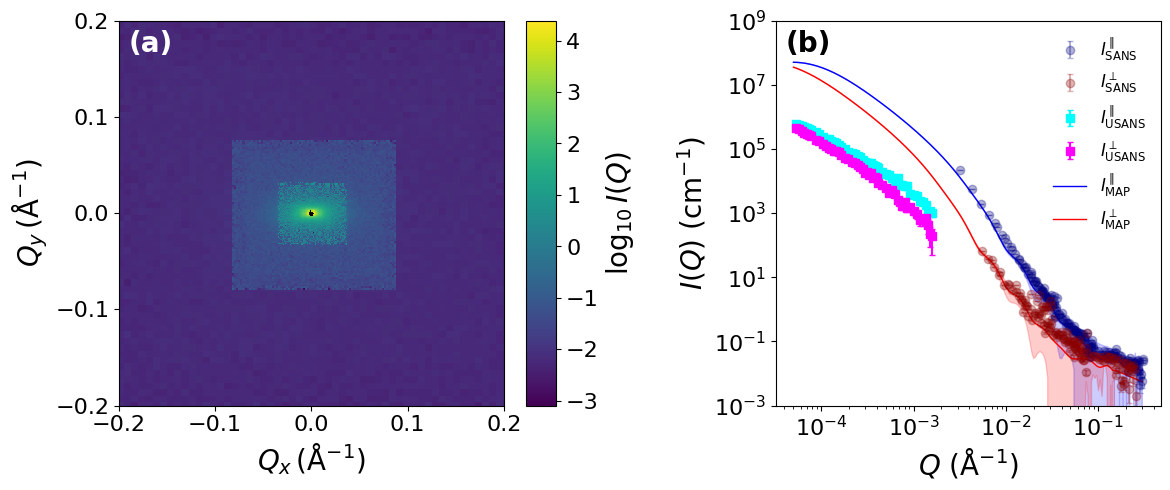

In [20]:
# plot smeared EQSANS with SANS data
fig, axs = plt.subplots(
    ncols=2, nrows=1,
    figsize=(15, 5),
    constrained_layout=False
)

panel_labels = ['(a)', '(b)']

# ------------------ Right panel: 1D log-log ------------------
ax = axs[1]
ax.text(0.025, 0.975, panel_labels[1], transform=ax.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left')

handles = []
labels  = []

h = ax.errorbar(Q_obs_sans_para, I_obs_sans_para, yerr=dI_obs_sans_para,
                fmt='o', label='EQSANS Parallel', color='navy', alpha=0.3, capsize=2)
handles.append(h); labels.append(r'$I_\mathrm{SANS}^\parallel$')

h = ax.errorbar(Q_obs_sans_perp, I_obs_sans_perp, yerr=dI_obs_sans_perp,
                fmt='o', label='EQSANS Perpendicular', color='darkred', alpha=0.3, capsize=2)
handles.append(h); labels.append(r'$I_\mathrm{SANS}^\perp$')

h = ax.errorbar(Q_obs_usans_para, I_obs_usans_para, yerr=dI_obs_usans_para,
                fmt='s', color='cyan', alpha=1, capsize=2)
handles.append(h); labels.append(r'$I_\mathrm{USANS}^\parallel$')

h = ax.errorbar(Q_obs_usans_perp, I_obs_usans_perp, yerr=dI_obs_usans_perp,
                fmt='s', color='magenta', alpha=1, capsize=2)
handles.append(h); labels.append(r'$I_\mathrm{USANS}^\perp$')

# --- MAP prediction (para/perp) -----------------------------------------
h, = ax.plot(Q_obs, I_map_para, color='b', linestyle='-', linewidth=1)
handles.append(h); labels.append(r'$I_\mathrm{MAP}^\parallel$')

ax.fill_between(Q_obs,
                I_map_para - Delta_I_map_para*c_opt,
                I_map_para + Delta_I_map_para*c_opt,
                color='b', alpha=0.2)

h, = ax.plot(Q_obs, I_map_perp, color='r', linestyle='-', linewidth=1)
handles.append(h); labels.append(r'$I_\mathrm{MAP}^\perp$')

ax.fill_between(Q_obs,
                I_map_perp - Delta_I_map_perp*c_opt,
                I_map_perp + Delta_I_map_perp*c_opt,
                color='r', alpha=0.2)

ax.set_ylim(1e-3, 1e9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$Q$ (Å$^{-1}$)", fontsize=20)
ax.set_ylabel(r"$I(Q)$ (cm$^{-1}$)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(handles, labels, fontsize=12, frameon=False, ncol=1)

# Make right panel square (physical box)
ax.set_box_aspect(1)

# ------------------ Left panel: 2D spectrum ------------------
ax0 = axs[0]
ax0.text(0.025, 0.975, panel_labels[0], transform=ax0.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left', color='w')
c = ax0.pcolormesh(Qx_grid_hq, Qy_grid_hq, np.log10(I_grid_hq*fac_para['hq']),
                   cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_hq).astype(float))
c = ax0.pcolormesh(Qx_grid_mq, Qy_grid_mq, np.log10(I_grid_mq*fac_para['mq']),
                   cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_mq).astype(float))
c = ax0.pcolormesh(Qx_grid_lq, Qy_grid_lq, np.log10(I_grid_lq),
                   cmap='viridis', shading='auto', alpha=np.isfinite(I_grid_lq).astype(float))

ax0.set_xlabel(r'$Q_x \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax0.set_ylabel(r'$Q_y \, (\mathrm{\AA}^{-1})$', fontsize=20)
ax0.set_xlim(-0.2, 0.2)
ax0.set_ylim(-0.2, 0.2)
ax0.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
ax0.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
ax0.tick_params(axis='both', which='major', labelsize=16)
ax0.set_facecolor('k')

# Enforce square data + square box
ax0.set_aspect('equal', adjustable='box')
ax0.set_box_aspect(1)

# ------------------ Dedicated colorbar axis (does NOT shrink ax0) ------------------
# First, set subplot spacing (so we know final ax0 position)
plt.subplots_adjust(wspace=0.30)

# Now create colorbar axis with same height as ax0
bbox = ax0.get_position()
cax = fig.add_axes([
    bbox.x1 + 0.015,   # x position to the right of ax0
    bbox.y0,           # align bottom
    0.02,              # width
    bbox.height        # match height
])

cbar = fig.colorbar(c, cax=cax)
cbar.set_label(r'$\log_{10}I(Q)$', fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.show()
